# Attempted Implementation of Yadav and Gupta's Multimodal Fake News Detection Approach on *Fakeddit*

## Environment Setup 

**EmoSet GitHub**: https://github.com/JingyuanYY/EmoSet

**Fakeddit GitHub**: https://github.com/entitize/Fakeddit

**Reference for how to extract image features using 16x6-kernel ViT base image transformer (12 multi-head attention heads):**
https://stackoverflow.com/questions/75874965/how-do-i-extract-features-from-a-torchvision-visitiontransfomer-vit
--> This post was very useful for instructing how to extract image features as the final [CLS] token just like for NLP transformers

**Reference for VGG-16 pre-trained model fine-tuning**:
https://medium.com/@qakunnath/fine-tuning-a-pre-trained-vgg16-model-for-custom-image-classification-b1fd4bf56aad

In [1]:
# Imports required libraries
import os
import json
# Imports re for regex text preprocessing
import re 
# Imports basic data processing and visualization libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm 
tqdm.pandas()
# Imports HuggingFace Datasets functionality for Fakeddit and EmoSet datasaets
from datasets import Dataset, DatasetDict, load_dataset, load_from_disk
# For auto-loading of the DistilBERT model
from transformers import AutoModel, AutoTokenizer
# Imports the memory-clearing garbage collection when working with large datasets
import gc 

# Imports the image-reading and loading libraries
from PIL import Image
from io import BytesIO
 
# Imports the custom class for processing the EmoSet datasets, downloaded from EmoSet GitHub
from EmoSet import EmoSet

# Imports the PyTorch functionality for integration with the transformers Datasets and for neural network model training (fine-tuning EmoSet)
import torch
# For loading in Datasets with PyTorch
from torch.utils.data import DataLoader
# Imports the pretrained Vision Transformer model and its preprocessing/weights
from torchvision.models.vision_transformer import vit_b_16, ViT_B_16_Weights 
# Imports for loading in VGG-16 for EmoSet tuning
from torchvision import datasets, models, transforms
# Imports for building the classifier's neural network layers
import torch.nn as nn
# Imports the torch functional API to create softmax layer
import torch.nn.functional as F
# Imports Adam optimizer for the neural network
from torch.optim import Adam
# Imports ReduceLROnPlateau dynamically adjusting learning rate when neural network performance plateaus
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Imports TensorFlow and Keras API functionality as before for training and evaluating the final model
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import F1Score

# Imports the scikit-learn metrics, Standard and MinMax scalers and the Passive-Aggressive classifier for computing quick baselines
from sklearn.metrics import accuracy_score,f1_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import PassiveAggressiveClassifier

In [70]:
# Loads in the Fakeddit dataset (train, val test) - "clean" prefix means duplicates & non-English entries and NaN-text fields removed
train_df = pd.read_csv("../../FPData/Fakeddit/clean_train.csv")
val_df = pd.read_csv("../../FPData/Fakeddit/clean_val.csv")
test_df = pd.read_csv("../../FPData/Fakeddit/clean_test.csv")

In [71]:
# Creates a hasImage column for all Fakeddit splits (if it doesn't already exist) which stores True if the row is
# associated with an image URL, and False if it isn't and contains text only
train_df["hasImage"] = train_df["image_url"].notna()
val_df["hasImage"] = val_df["image_url"].notna()
test_df["hasImage"] = test_df["image_url"].notna()

In [72]:
# Saves these datasets back with the "hasImage" field
train_df.to_csv("../../FPData/Fakeddit/clean_train.csv")
val_df.to_csv("../../FPData/Fakeddit/clean_val.csv")
test_df.to_csv("../../FPData/Fakeddit/clean_test.csv") # Save train/val/test sets with hasImage column

In [73]:
# Verifies that the dataset lengths are different
print(len(train_df), len(val_df), len(test_df))

648076 70332 71095


## Loading in the Image .jpg Files

### Extracts the IDs (filenames) of Train, Val and Test Images to Match with DataFrame "id" Column

In [58]:
# Sets up relative filepaths for image .jpg files for each of the dataset splits
image_folders = {
    "train": "../../FPData/Fakeddit/Fakeddit_Image/train_images",
    "val": "../../FPData/Fakeddit/Fakeddit_Image/val_images", 
    "test": "../../FPData/Fakeddit/Fakeddit_Image/test_images", 
}

In [59]:
# Prints out how many images there are in each split's directory
def printNumImages(image_folders, split):
    # Extracts the folder path based on the image_folders dict above
    folder_path = image_folders[split]
    # Counts num images in the folder
    num_images = len(os.listdir(folder_path))
    # Return the count
    return num_images

In [60]:
num_train_images = printNumImages(image_folders, "train")
num_val_images = printNumImages(image_folders, "val")
num_test_images = printNumImages(image_folders, "test")

print(f"There are {num_train_images} training images, {num_val_images} validation images, and {num_test_images} test images in this dataset.")

There are 332605 training images, 35488 validation images, and 35892 test images in this dataset.


In [14]:
# Extracts the IDs from the file names of the images in each of the folders
def getImageIDs(image_folders, split):
    # Extracts the folder path based on the image_folders dict above
    folder_path = image_folders[split]
    # Extracts the image id, which is the part of the image's filename before the ".jpg" string/extension
    image_ids = [image_file.split(".jpg")[0] for image_file in os.listdir(folder_path) if image_file.endswith(".jpg")]
    return image_ids

In [15]:
# Uses the function above to extract the image IDs from the train/test/val folders
train_image_ids = getImageIDs(image_folders, "train")
val_image_ids = getImageIDs(image_folders, "val")
test_image_ids = getImageIDs(image_folders, "test")

# Verifies the num images again
print(f"There are {len(train_image_ids)} training image IDs, {len(val_image_ids)} validation image IDs, and {len(test_image_ids)} test image IDs in this dataset.")

There are 332605 training image IDs, 35488 validation image IDs, and 35892 test image IDs in this dataset.


In [16]:
# Now filters the DataFrames to ONLY keep the rows with the extracted image IDs, use astype(str) to ensure col value is treated as a string
train_df = train_df[train_df["id"].astype(str).isin(train_image_ids)]
val_df = val_df[val_df["id"].astype(str).isin(val_image_ids)]
test_df = test_df[test_df["id"].astype(str).isin(test_image_ids)]

In [17]:
# Now verifies the DataFrame lengths
print(f"There are {len(train_df)} training rows, {len(val_df)} validation rows, and {len(test_df)} test rows in this dataset.")

There are 332605 training rows, 35488 validation rows, and 35892 test rows in this dataset.


In [18]:
# Adds a new column to the pandas DataFrames storing the image paths.
# Uses the DataFrame "id" folders to apply a function joining the image folder path with os.path.join with the image id and the .jpg extension
train_df["image_path"] = train_df["id"].astype(str).progress_apply(
    lambda image_id: os.path.join(image_folders["train"], f"{image_id}.jpg")
)

val_df["image_path"] = val_df["id"].astype(str).progress_apply(
    lambda image_id: os.path.join(image_folders["val"], f"{image_id}.jpg")
)

test_df["image_path"] = test_df["id"].astype(str).progress_apply(
    lambda image_id: os.path.join(image_folders["test"], f"{image_id}.jpg")
)

  0%|          | 0/332605 [00:00<?, ?it/s]

  0%|          | 0/35488 [00:00<?, ?it/s]

  0%|          | 0/35892 [00:00<?, ?it/s]

## Preprocessing and Cleaning Datasets

In [4]:
# Text cleaning and pre-processing in preparation for DistilBERT embeddings
# For DistilBERT and other transformers, tokenization or lemmatization is not necessary as this is handled
# by the transformers library
# However, it is necessary to remove things like redundant newline characters and trailing whitespace, as well
# as HTML tags and URLs
# Lowercasing will be applied as DistilBERT/BERT-uncased used in the Yadav and Gupta study expects no capital letters
# Reference: https://medium.com/@prakashram1327/building-a-text-classification-model-using-distilbert-703c1409696c

def cleanTextForDistilBERT(text):
    """
    Takes in a text string and applies RegEx to clean from redundant whitespace and other special strings such
    as HTML tags. Lowercases the text in preparation for the uncased transformer model.
    Reference for code this is based on: 
        https://medium.com/@prakashram1327/building-a-text-classification-model-using-distilbert-703c1409696c
        
        Input Parameters:
            text (str): the text to be cleaned
        Output:
            text (str): the now cleaned text
    """
    # Lowercases the text
    text = text.lower()
    # Removes HTML tags
    text = re.sub(r"<.*?>", '', text)
    # Removes URLs starting with http
    text = re.sub(r"http\S+", '', text)
    # Removes other URLs. Reference: https://uibakery.io/regex-library/url-regex-python
    text = re.sub(r"^[-a-zA-Z0-9@:%._\\+~#=]{1,256}\\.[a-zA-Z0-9()]{1,6}\\b(?:[-a-zA-Z0-9()@:%_\\+.~#?&\\/=]*)$",
                  '', text)
    # Removes email addresses, reference: https://uibakery.io/regex-library/email-regex-python
    text = re.sub(r"^[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*@(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?$" ,
                  '', text)  
    # Removes phone numbers (basic 10-digit format). Reference: https://uibakery.io/regex-library/phone-number-python
    text = re.sub("^\\+?[1-9][0-9]{7,14}$",
                  '', text)  
    # Remove trailing spaces and replace with single space
    text = re.sub(r"\s+", " ", text).strip()
    return text


def removeEmptyRows(df, text_column_name="clean_text"):
    """
    Removes rows where the "text" column's value is empty or contains only whitespace.
    This could be the case after regular expression cleaning!
    
        Input Parameters:
            df (pandas.DataFrame): The DataFrame to clean.
            text_column_name (str): The column name containing the text data. The default is "text".
            
        Output:
            df (pandas.DataFrame): The cleaned dataframe with rows where "text" is empty removed.
    """
    
    # Strips whitespace from text entry using the .str method --> uses ".ne" = not equal to determine if
    # text is not equal to an empty string after stripping any trailing whitespace
    # Reference: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ne.html
    df = df[df[text_column_name].str.strip().ne('')]

    return df


In [21]:
# Cleans the text column using the functions above and then remove empty rows from train/val/test DataFames
train_df["cleaned_text_for_distilbert"] = train_df["text"].progress_apply(cleanTextForDistilBERT)
val_df["cleaned_text_for_distilbert"] = val_df["text"].progress_apply(cleanTextForDistilBERT)
test_df["cleaned_text_for_distilbert"] = test_df["text"].progress_apply(cleanTextForDistilBERT)

print(f"Length of training set before removing empty rows: {len(train_df)}, length of validation set: {len(val_df)}, length of test set: {len(test_df)}")

# Removes the resulting empty rows
train_df = removeEmptyRows(train_df, text_column_name = "cleaned_text_for_distilbert")
val_df = removeEmptyRows(val_df, text_column_name = "cleaned_text_for_distilbert")
test_df = removeEmptyRows(test_df, text_column_name = "cleaned_text_for_distilbert")

print(f"Length of training set after removing empty rows: {len(train_df)}, length of validation set: {len(val_df)}, length of test set: {len(test_df)}")

  0%|          | 0/332605 [00:00<?, ?it/s]

  0%|          | 0/35488 [00:00<?, ?it/s]

  0%|          | 0/35892 [00:00<?, ?it/s]

Length of training set before removing empty rows: 332605, length of validation set: 35488, length of test set: 35892
Length of training set after removing empty rows: 332604, length of validation set: 35487, length of test set: 35892


In [ ]:
# dataset.map: apply a processing function to each examples in a dataset
# Reference: https://huggingface.co/docs/datasets/v1.1.1/processing.html

In [23]:
# Filters columns to select only the important ones before creating a Dataset object
important_cols = [
    "id",
    "num_comments", "score", "subreddit", "upvote_ratio", # Keep these in case decide to add these features later, if there is time/or for future work
     "label", "image_path", "cleaned_text_for_distilbert" # Important for this task!!!!!
]

train_df_filtered = train_df.loc[:, important_cols]
val_df_filtered = val_df.loc[:, important_cols]
test_df_filtered = test_df.loc[:, important_cols]

In [24]:
train_df_filtered.head()

id  num_comments  score          subreddit  upvote_ratio  label  \
0  awxhir           2.0     12  mildlyinteresting          0.84      0   
2  6f2cy5           1.0     44        neutralnews          0.92      0   
4  4xypkv          26.0    250   photoshopbattles          0.95      0   
7  2vkbtj           7.0      6        nottheonion          0.64      0   
8  6d50rl           0.0      2         pareidolia          0.67      1   

                                          image_path  \
0  ../../FPData/Fakeddit/Fakeddit_Image/train_ima...   
2  ../../FPData/Fakeddit/Fakeddit_Image/train_ima...   
4  ../../FPData/Fakeddit/Fakeddit_Image/train_ima...   
7  ../../FPData/Fakeddit/Fakeddit_Image/train_ima...   
8  ../../FPData/Fakeddit/Fakeddit_Image/train_ima...   

                         cleaned_text_for_distilbert  
0  my walgreens offbrand mucinex was engraved wit...  
2      hackers leak emails from uae ambassador to us  
4                 psbattle: puppy taking in the view  
7  bride and groom exchange vows after fatal shoo...  
8                                      major thermos

In [25]:
# Converts the DataFrames to Hugging Face Dataset objects, to save memory when creating large embeddings and feature matrices
train_dataset = Dataset.from_pandas(train_df_filtered)
val_dataset = Dataset.from_pandas(val_df_filtered)
test_dataset = Dataset.from_pandas(test_df_filtered)

In [27]:
# Creates a Fakeddit DatasetDict containing the train, val and test set
fakeddit_dataset_dict = DatasetDict({
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset
})

In [33]:
fakeddit_dataset_dict.save_to_disk("../../FPData/Fakeddit/Fakeddit_Image/fakeddit_dataset_with_image_paths") # Save Dataset to disk

Saving the dataset (0/1 shards):   0%|          | 0/332604 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/35487 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/35892 [00:00<?, ? examples/s]

In [2]:
# # Loads the Dataset back in:
fakeddit_dataset_dict = load_from_disk("../../FPData/Fakeddit/Fakeddit_Image/fakeddit_dataset_with_image_paths")

## Extracting CLS Image Embeddings (Features) Using the Pre-Trained ViT Image Transformer Model

### References for ViT pre-trained transformer:

- https://medium.com/@diego.machado/fine-tuning-vit-for-image-classification-with-hugging-face-48c4be31e367
- https://github.com/huggingface/transformers/blob/main/docs/source/en/tasks/image_feature_extraction.md
- https://huggingface.co/docs/datasets/v1.1.1/processing.html

### Why ViT-Base 16?

- Original research paper this is based on (Yadav and Gupta, 2024), specifying **224*224** resolution and **16x16** patches:

        "In the multi-granular visual feature extraction module, the images are normalized and resized to 224*224 size. The kernel size used in the Conv2D layer is 16*16. We use twelve parallel attention heads."


<br>

- From the [ViT-Base 16 description](https://huggingface.co/google/vit-base-patch16-224) on HuggingFace site:
    - "Vision Transformer (ViT) model pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution **224x224**, and fine-tuned on ImageNet 2012 (1 million images, 1,000 classes) at resolution 224x224. It was introduced in the paper An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale by Dosovitskiy et al. and first released in this repository. However, the weights were converted from the timm repository by Ross Wightman, who already converted the weights from JAX to PyTorch. Credits go to him."
    - "Images are presented to the model as a sequence of fixed-size patches **(resolution 16x16)**, which are linearly embedded. One also adds a [CLS] token to the beginning of a sequence to use it for classification tasks. One also adds absolute position embeddings before feeding the sequence to the layers of the Transformer encoder."
    - Num of attention heads [defaults to 12](https://huggingface.co/docs/transformers/en/model_doc/vit)

Therefore, this model was selected as its configuration closely matched the architecture described in the original research paper inspiring this approach.

In [76]:
# Reference for how to extract features using Vision Transformer
# Reference: https://stackoverflow.com/questions/75874965/how-do-i-extract-features-from-a-torchvision-visitiontransfomer-vit

# Sets up the ViT transformer
"""
    "Vision Transformer (ViT) model pre-trained on ImageNet-21k (14 million images, 21,843 classes) 
    at resolution 224x224, and fine-tuned on ImageNet 2012 (1 million images, 1,000 classes) at resolution 224x224.
    It was introduced in the paper An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale by
    Dosovitskiy et al. and first released in this repository. However, the weights were converted from the timm 
    repository by Ross Wightman, who already converted the weights from JAX to PyTorch. Credits go to him."
    
    - https://huggingface.co/google/vit-base-patch16-224
"""

# Loads in the pre-trained ViT transformer model with default weights
model = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)

# Sets the ViT model to eval non-train mode --> not using model for training but for extracting features here, so let's disable dropout etc.
# Reference: https://www.geeksforgeeks.org/what-does-model-eval-do-in-pytorch/
model.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [77]:
# Extracts the image preprocessing steps the ViT pre-trained model and inspects the transforms
preprocessing = ViT_B_16_Weights.DEFAULT.transforms()
preprocessing

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [78]:
def getCLSImageEmbedding(news_sample, model, preprocessing):
    """
    Tries to load an image from .jpg path as PIL file with RGB mode. Returns None if image cannot be loaded.
    Uses the preprocessing transforms from torch ViT model to resize, crop, normalize the image etc. to be
    consistent with the training data used to pre-train the ViT model. Then uses the pre-trained ViT
    transformer model to cut the image into "patches" (subsections) and use multi-head attention calculations
    to extract embeddings for the image sections. Use the first general CLS embedding (just like with NLP tasks
    based on transformers) to encode the image for further processing.

        Reference: https://stackoverflow.com/questions/75874965/how-do-i-extract-features-from-a-torchvision-visitiontransfomer-vit

        Input Parameters:
            news_sample (dict): sample to process the image for
            model (torchvision.models.vision_transformer.VisionTransformer): the pre-trained image transformer model
            preprocessing (torchvision.transforms._presets.ImageClassification): the transforms to apply to the image, e.g. resize, normalize

        Output:
            dict: a dictionary storing "cls_embedding" as the key and either a NumPy array containing the
                    embedding or None if the image is invalid
    """
    image_path = news_sample["image_path"]
    
    # Tries to load the image, return a dict storing the CLS embedding as None if it the .jpg image is invalid and cannot be opened
    try:
        
        # Converts to RGBA first due to UserWarning about transparency channel, then convert to RGB and extract as a PIL Image object
        image = Image.open(image_path).convert("RGBA").convert("RGB") 
        
        # Applies transforms from the pre-trained ViT preprocessing pipeline
        preprocessed_image = preprocessing(image)
        
        # Adds the batch dimension to the beginning of the processed image (will be 1)
        preprocessed_image = preprocessed_image.unsqueeze(0)
 
        with torch.no_grad(): # No gradients/training required to extract features, so add no_grad for greater speed
            
            # Processes the image using ViT into patches/individual image sub-component units for multi-head attention calculations
            inputs = model._process_input(preprocessed_image)
            
            # Expands the CLS "class token" size to include the batch embedding --> 
            # (1, 1, embedding_size [768]) to (batch_size, 1, embedding_size [768]). Keep other dimensions the same
            batch_class_token = model.class_token.expand(preprocessed_image.shape[0], -1, -1)

            # Concatenates the CLS token to the other patch embeddings for each sample (at dimension 1 in the tensor)
            inputs = torch.cat([batch_class_token, inputs], dim=1)

            # Extracts the embeddings with pre-trained model
            feature_embeddings = model.encoder(inputs)

            # Extracts the CLS embedding at position 0 for model training, remove the single batch dimension with .squeeze() method
            cls_embedding = feature_embeddings[:, 0].squeeze()

        return {"cls_embedding": cls_embedding.cpu().numpy()}

    # Returns value of None if image is invalid
    except Exception as e:
        print(f"Could not open or process the image stored at {image_path}. Error: {e}!!!!!")
        return {"cls_embedding": None}

In [80]:
# Applies the function to the train, val and test dataset splits to create a new "cls_embedding" key

# Training set
train_dataset = fakeddit_dataset_dict["train"].map(
    lambda sample: getCLSImageEmbedding(sample, model, preprocessing)
)

Map:   0%|          | 0/332604 [00:00<?, ? examples/s]

Could not open or process the image stored at ../../FPData/Fakeddit/Fakeddit_Image/train_images/d5evm0v.jpg. Error: cannot identify image file '/Users/ophelia/Documents/FinalProject/FPData/Fakeddit/Fakeddit_Image/train_images/d5evm0v.jpg'!!!!!
Could not open or process the image stored at ../../FPData/Fakeddit/Fakeddit_Image/train_images/c87n4gu.jpg. Error: cannot identify image file '/Users/ophelia/Documents/FinalProject/FPData/Fakeddit/Fakeddit_Image/train_images/c87n4gu.jpg'!!!!!
Could not open or process the image stored at ../../FPData/Fakeddit/Fakeddit_Image/train_images/ckk18va.jpg. Error: cannot identify image file '/Users/ophelia/Documents/FinalProject/FPData/Fakeddit/Fakeddit_Image/train_images/ckk18va.jpg'!!!!!
Could not open or process the image stored at ../../FPData/Fakeddit/Fakeddit_Image/train_images/cea9g9y.jpg. Error: cannot identify image file '/Users/ophelia/Documents/FinalProject/FPData/Fakeddit/Fakeddit_Image/train_images/cea9g9y.jpg'!!!!!
Could not open or proces

In [88]:
# Validation set
val_dataset = fakeddit_dataset_dict["val"].map(
    lambda sample: getCLSImageEmbedding(sample, model, preprocessing)
)

Map:   0%|          | 0/35487 [00:00<?, ? examples/s]

Could not open or process the image stored at ../../FPData/Fakeddit/Fakeddit_Image/val_images/c4dbi8e.jpg. Error: cannot identify image file '/Users/ophelia/Documents/FinalProject/FPData/Fakeddit/Fakeddit_Image/val_images/c4dbi8e.jpg'!!!!!
Could not open or process the image stored at ../../FPData/Fakeddit/Fakeddit_Image/val_images/ch1pcor.jpg. Error: cannot identify image file '/Users/ophelia/Documents/FinalProject/FPData/Fakeddit/Fakeddit_Image/val_images/ch1pcor.jpg'!!!!!
Could not open or process the image stored at ../../FPData/Fakeddit/Fakeddit_Image/val_images/cmk2pxb.jpg. Error: cannot identify image file '/Users/ophelia/Documents/FinalProject/FPData/Fakeddit/Fakeddit_Image/val_images/cmk2pxb.jpg'!!!!!
Could not open or process the image stored at ../../FPData/Fakeddit/Fakeddit_Image/val_images/d6ww1kw.jpg. Error: cannot identify image file '/Users/ophelia/Documents/FinalProject/FPData/Fakeddit/Fakeddit_Image/val_images/d6ww1kw.jpg'!!!!!
Could not open or process the image stor

In [90]:
# Test set
test_dataset = fakeddit_dataset_dict["test"].map(
    lambda sample: getCLSImageEmbedding(sample, model, preprocessing)
)

Map:   0%|          | 0/35892 [00:00<?, ? examples/s]

Could not open or process the image stored at ../../FPData/Fakeddit/Fakeddit_Image/test_images/d761gbz.jpg. Error: cannot identify image file '/Users/ophelia/Documents/FinalProject/FPData/Fakeddit/Fakeddit_Image/test_images/d761gbz.jpg'!!!!!
Could not open or process the image stored at ../../FPData/Fakeddit/Fakeddit_Image/test_images/e4za8ky.jpg. Error: cannot identify image file '/Users/ophelia/Documents/FinalProject/FPData/Fakeddit/Fakeddit_Image/test_images/e4za8ky.jpg'!!!!!
Could not open or process the image stored at ../../FPData/Fakeddit/Fakeddit_Image/test_images/c9s1x1s.jpg. Error: cannot identify image file '/Users/ophelia/Documents/FinalProject/FPData/Fakeddit/Fakeddit_Image/test_images/c9s1x1s.jpg'!!!!!
Could not open or process the image stored at ../../FPData/Fakeddit/Fakeddit_Image/test_images/e5e5ngf.jpg. Error: cannot identify image file '/Users/ophelia/Documents/FinalProject/FPData/Fakeddit/Fakeddit_Image/test_images/e5e5ngf.jpg'!!!!!
Could not open or process the im

In [91]:
# Creates a new Fakeddit DatasetDict containing the train, val and test set and the image embeddings
fakeddit_vision_transformer_embeddings_dataset_dict = DatasetDict({
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset
})

In [99]:
# Uses the HuggingFace Datasets .filter method to remove rows where the CLS embedding is None
# Reference: https://huggingface.co/docs/datasets/v1.1.1/package_reference/main_classes.html#datasets.Dataset.filter
# https://medium.com/@pi_45757/working-with-datasets-on-hugging-face-478e1a47c7b6

filtered_fakeddit_vision_transformer_embeddings_dataset_dict = fakeddit_vision_transformer_embeddings_dataset_dict.filter(
    lambda row: row["cls_embedding"] is not None
)

Filter:   0%|          | 0/332604 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35487 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35892 [00:00<?, ? examples/s]

In [100]:
# Saves the filtered Fakeddit DatasetDict containing the train, val and test set and the image embeddings to disk
filtered_fakeddit_vision_transformer_embeddings_dataset_dict.save_to_disk(
    "../../FPData/Fakeddit/Fakeddit_Image/filtered_fakeddit_dataset_with_image_embeddings"
)

Saving the dataset (0/3 shards):   0%|          | 0/332501 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/35470 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/35873 [00:00<?, ? examples/s]

In [120]:
# Loads the filtered dataset with CLS embeddings back in
filtered_fakeddit_vision_transformer_embeddings_dataset_dict = load_from_disk(
    "../../FPData/Fakeddit/Fakeddit_Image/filtered_fakeddit_dataset_with_image_embeddings"
)

In [121]:
filtered_fakeddit_vision_transformer_embeddings_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['id', 'num_comments', 'score', 'subreddit', 'upvote_ratio', 'label', 'image_path', 'cleaned_text_for_distilbert', '__index_level_0__', 'cls_embedding'],
        num_rows: 332501
    })
    val: Dataset({
        features: ['id', 'num_comments', 'score', 'subreddit', 'upvote_ratio', 'label', 'image_path', 'cleaned_text_for_distilbert', '__index_level_0__', 'cls_embedding'],
        num_rows: 35470
    })
    test: Dataset({
        features: ['id', 'num_comments', 'score', 'subreddit', 'upvote_ratio', 'label', 'image_path', 'cleaned_text_for_distilbert', '__index_level_0__', 'cls_embedding'],
        num_rows: 35873
    })
})

In [110]:
# Prints the lengths of splits before filtering:
print(f"Length of training rows before filtering: {len(fakeddit_vision_transformer_embeddings_dataset_dict["train"])}")
print(f"Length of val rows before filtering: {len(fakeddit_vision_transformer_embeddings_dataset_dict["val"])}")
print(f"Length of test rows before filtering: {len(fakeddit_vision_transformer_embeddings_dataset_dict["test"])}")

print(f"\nLength of training rows after filtering: {len(filtered_fakeddit_vision_transformer_embeddings_dataset_dict["train"])}")
print(f"Length of val rows after filtering: {len(filtered_fakeddit_vision_transformer_embeddings_dataset_dict["val"])}")
print(f"Length of test rows after filtering: {len(filtered_fakeddit_vision_transformer_embeddings_dataset_dict["test"])}")

Length of training rows before filtering: 332604
Length of val rows before filtering: 35487
Length of test rows before filtering: 35892

Length of training rows after filtering: 332501
Length of val rows after filtering: 35470
Length of test rows after filtering: 35873


## Fine-Tuning the Pre-Trained Convolutional VGG-16 Model on [EmoSet](https://github.com/JingyuanYY/EmoSet/tree/main)

- The EmoSet dataset can be found here: [link](https://github.com/JingyuanYY/EmoSet/tree/main)
- The EmoSet 118K version was used (the smaller one) due to computational resource limitations
- From the GitHub repository ReadMe:

        "The EmoSet Dataset is a class in PyTorch's Dataset module. It is designed for tasks related to emotions and each attributes, and specifically handles loading, transforming, and serving the data."

- This is consistent with the Dataset library that has been used so far
- The instructions on the GitHub repository were used to download the dataset, and to load in the datasets (train/val/test) from the root EmoSet directory
- Docs for VGG-16 model with PyTorch: [link to model description](https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html)

### Problems with the EmoSet Instructions and Format on the GitHub Repository

Downloading and getting the EmoSet datasets to work was a long process. This was due to the fact that instructions on how to load the Datasets on GitHub were completely incorrect. Firstly, the *info.json* file mapping labels to indices using a "label2idx" and "idx2label" key in JSON format was wrong, because the Dataset expected this information to be wrapped in an *emotion* key as shown below:

{
  "emotion": {
    "label2idx": {
      "amusement": 0,
      "awe": 1,
      "contentment": 2,
      "excitement": 3,
      "anger": 4,
      "disgust": 5,
      "fear": 6,
      "sadness": 7
    },
    "idx2label": {
      "0": "amusement",
      "1": "awe",
      "2": "contentment",
      "3": "excitement",
      "4": "anger",
      "5": "disgust",
      "6": "fear",
      "7": "sadness"
    }
  }
}


which was NOT the case in the downloaded info.json file, leading to a KeyError.

Secondly, the GitHub Read Me clearly states that the Dataset loader expects the train/val/test.json file to contain the following structure:

[
    [
        "amusement",
        "amusement_12865",
        "image/amusement/amusement_12865.jpg",
        "annotation/amusement/amusement_12865.json"
    ],
    ...
]

However, in fact, the train/val/test.json files contain this structure:

[
  [
    "amusement",
    "image/amusement/amusement_08258.jpg",
    "annotation/amusement/amusement_08258.json"
  ],
  [
    "excitement",
    "image/excitement/excitement_17835.jpg",
    "annotation/excitement/excitement_17835.json"
  ],
  [
    "excitement",
    "image/excitement/excitement_09581.jpg",
    "annotation/excitement/excitement_09581.json"
  ],...
]

Which means that another error (IndexError) is generated when trying to use the .json files to create the datasets Dataset instance.

As a result, the following script had to be run in order to get the train/val/test.json files into the correct structure, with the image ID as the second key, which was missing from the original data. This was tedious and time consuming, and irritating the original authors did not mention that their instructions on GitHub would not work due to this omission in the JSON structure.

In [21]:
# Sets up the root path to the EmoSet directory
data_root = "../../FPData/Fakeddit/Fakeddit_Image/EmoSet/"

train_path = os.path.join(data_root, "train.json")
val_path = os.path.join(data_root, "val.json")
test_path = os.path.join(data_root, "test.json")

In [127]:
def changeToValidJSON(file_path):
    """
    Changes the JSON dataset downloaded from the EmoSet directory to be in the valid format, to get the same keys as 
    specified for usage in the EmoSet GitHub repository, as the second ID key was missing, causing incompatibilities
    and IndexErrors.

        Input Parameters:
                file_path (str): EmoSet JSON file path (training, validation, or test JSON files)
    """
    
    # Loads the JSON in
    with open(file_path, 'r') as f:
        invalid_json_dataset = json.load(f)

    # Creates new JSON dataset in the VALID format: 4 values for each image sample in a list which are:
    # 1. Emotion category 2. Image ID 3. Path to image 4. Path to annotation
    # Before, the item 2. (Image ID) was missing, leading to crashes in the code

    # Stores the new data here:
    valid_json_data = []

    # Iterates over the invalid JSON image data
    for image_item in invalid_json_dataset:
        # Extracts the emotion name, e.g. "amusement"
        emotion_label = image_item[0]
        # Extracts the image path
        image_path = image_item[1]
        # Extracts the image annotation path
        annotation_path = image_item[2]
        # Now extracts the image ID using .split and indexing
        # AIM: to get the "amusement_08258" out of "image/amusement/amusement_08258.jpg" to store in 2nd key
        # 1. Splits by the / and extract the last "amusement_08258.jpg" part
        image_file_name = image_path.split('/')[-1]
        # 2. Splits on the '.' to remove hte .jpg extension
        image_id = image_file_name.split('.')[0]

        # Now creates a new JSON entry for the valid_json_data list
        valid_json_data.append([emotion_label, image_id, image_path, annotation_path])

    # Saves the new JSON dataset by overwriting the original .json file
    # Reference: https://www.geeksforgeeks.org/json-dump-in-python/
    with open(file_path, 'w') as f:
        json.dump(valid_json_data, f, indent=4) # Adds indentation to improve JSON file readability

    print(f"JSON data has been updated, and {file_path} has been overwritten.")

In [128]:
# Applies the JSON-fixing code to all the EmoSet spits
changeToValidJSON(train_path)
changeToValidJSON(val_path)
changeToValidJSON(test_path)

JSON data has been updated, and ../../FPData/Fakeddit/Fakeddit_Image/EmoSet/train.json has been overwritten.
JSON data has been updated, and ../../FPData/Fakeddit/Fakeddit_Image/EmoSet/val.json has been overwritten.
JSON data has been updated, and ../../FPData/Fakeddit/Fakeddit_Image/EmoSet/test.json has been overwritten.


In [22]:
# Now it is possible to actually load the EmoSet datasets as explained in the GitHub repository
num_emotion_classes = 8

train_dataset = EmoSet(
    data_root=data_root,
    num_emotion_classes=num_emotion_classes,
    phase="train",
)

val_dataset = EmoSet(
    data_root=data_root,
    num_emotion_classes=num_emotion_classes,
    phase="val",
)

test_dataset = EmoSet(
    data_root=data_root,
    num_emotion_classes=num_emotion_classes,
    phase="test",
)

# From the GitHub: "This dataset can be used with a DataLoader for batch processing:"
# From Medium: "We then create data loaders to fetch data in batches:"
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [23]:
# Checks if EmoSet DataLoaders work now after making various changes to the source code downloaded from the repository...
for i, data in enumerate(train_loader):
    print(f"Batch nr: {i + 1}:")
    print(f"\nImage ids: {data['image_id']}")
    print(f"\nEmotion labels: {data['emotion_label']}")
    print(f"\nEmotion indices: {data['emotion_label_idx']}")
    break # Break after inspecting a single batch

Batch nr: 1:

Image ids: ['amusement_07692', 'amusement_08923', 'awe_02816', 'awe_00426', 'amusement_14701', 'fear_03922', 'contentment_06767', 'excitement_15287', 'excitement_04440', 'excitement_15556', 'awe_11849', 'amusement_03878', 'contentment_01715', 'anger_07596', 'amusement_06710', 'awe_08218']

Emotion labels: ['amusement', 'amusement', 'awe', 'awe', 'amusement', 'fear', 'contentment', 'excitement', 'excitement', 'excitement', 'awe', 'amusement', 'contentment', 'anger', 'amusement', 'awe']

Emotion indices: tensor([0, 0, 1, 1, 0, 6, 2, 3, 3, 3, 1, 0, 2, 4, 0, 1])


It all seems to match now!

#### Notes on the Image Data Preprocessing

- **From Medium article on how to fine-tune a pre-trained VGG-16 model:** "Data preprocessing is crucial for the model to learn effectively. We use transformations to resize images, apply random horizontal flips (for data augmentation), convert images to tensors, and normalize them."
(https://medium.com/@qakunnath/fine-tuning-a-pre-trained-vgg16-model-for-custom-image-classification-b1fd4bf56aad)
    - "Resize: All images are resized to 224x224 pixels, the standard input size for VGG16."
    - "RandomHorizontalFlip: This randomly flips images horizontally, helping the model generalize better by seeing different orientations."
    - "Normalize:" The pixel values are normalized using mean and standard deviation values specific to ImageNet, ensuring compatibility with the pre-trained model.

<br>

The EmoSet Data Transformations listed on their [GitHub](https://github.com/JingyuanYY/EmoSet/tree/main) are:

- **For 'train' phase:**
    - Random resize crop to 224
    - Random horizontal flip
    - Conversion to tensor
    - Normalization.

<br>

- **For 'val' and 'test' phases:**
    - Resize to 224
    - Center crop to 224
    - Conversion to tensor
    - Normalization.

These transforms are integrated directly into the downloaded EmoSet.py class downloaded from the GitHub repository here:

```
    @classmethod
    def get_data_transforms(cls):
        transforms_dict = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'val': transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'test': transforms.Compose([
                transforms.Resize(224),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        }
        return transforms_dict
```

### Fine-Tuning VGG-16

#### Training the Model

["The training loop involves iterating over the dataset multiple times (epochs), processing images in batches"](https://medium.com/@qakunnath/fine-tuning-a-pre-trained-vgg16-model-for-custom-image-classification-b1fd4bf56aad)

Another problem was that the DataLoader class as detailed on the GitHub instructions did not work, due to a KeyError saying that certain attributes (e.g. 'brightness') were missing for certain images. On inspection, the annotations for each image contained completely different attributes (e.g. scene, colorfulness, brightness, object) which were present for some images and not for others. 

Another issue was also this:

```
    File ~/Documents/FinalProject/Notebooks/EmotionBasedTransformerNetwork/EmoSet.py:128, in EmoSet.__getitem__(self, item)
    126     attribute_label_idx = -1
    127     if attribute in annotation_data:
--> 128         attribute_label_idx = self.info[attribute]['label2idx'][str(annotation_data[attribute])]
    129     data.update({f'{attribute}_label_idx': attribute_label_idx})
    131 for attribute in self.ATTRIBUTES_MULTI_LABEL:
    132     # if empty, set to 0, else set to 1

KeyError: 'brightness'
```

The downloaded EmoSet.py code and the info.json code is trying to convert a brightness or colorfulness attribute of an image to a categorical label, when it is a floating-point value. However, info.json only contains an integer-to-string-label mapping to categories for emotions and not other categories! As such, a KeyError is thrown because info.json does not contain mappings for these other attributes. As these extra attributes are not actually required for fine-tuning the VGG-16 model based on the **emotion** label or attribute only, the EmoSet.py script had to be adapted to remove the loading of these other annotated attributes and only get the emotion label as an integer:

```
    def __getitem__(self, item):
        # Gets the emotion, img id, img path, annotation path from the json of this particular image item
        emotion_label, image_id, image_path, annotation_path = self.data_store[item]

        # Loads the image and apply the transforms
        image = self.load_image_by_path(image_path)

        # Gets the index of the emotion label using the info.json mapping
        emotion_label_idx = self.info['emotion']['label2idx'].get(emotion_label, -1) 
        
        data = {'image_id': image_id, 'image': image, 'emotion_label_idx': emotion_label_idx}

        ## COMMENTED OUT:
        # for attribute in self.ATTRIBUTES_MULTI_CLASS:
        #     # if empty, set to -1, else set to label index
        #     attribute_label_idx = -1
        #     if attribute in annotation_data:
        #         attribute_label_idx = self.info[attribute]['label2idx'][str(annotation_data[attribute])]
        #     data.update({f'{attribute}_label_idx': attribute_label_idx})

        # for attribute in self.ATTRIBUTES_MULTI_LABEL:
        #     # if empty, set to 0, else set to 1
        #     assert attribute == 'object'
        #     num_classes = self.NUM_CLASSES[attribute]
        #     attribute_label_idx = torch.zeros(num_classes)
        #     if attribute in annotation_data:
        #         for label in annotation_data[attribute]:
        #             attribute_label_idx[self.info[attribute]['label2idx'][label]] = 1
        #     data.update({f'{attribute}_label_idx': attribute_label_idx})

        return data

    def __len__(self):
        return len(self.data_store)
```

#### Fine-Tuning VGG-16 with EmoSet. using Dynamic Learning Rate Adjustment: For Improving Training when Validation Loss Stagnates

This reduces the learning rate (leading to smaller and more nuanced weight updates) whenever the validation loss stagnates.

In [2]:
num_emotion_classes = 8  # For extracting the probabilities of an image being in one of 8 emotion classes
batch_size = 64
num_epochs = 15  # Fine-tune for 15 epochs, considering computation and time restraints for now
# Use Mac metal for accelerated training
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device for training is {device}")

Device for training is mps


In [73]:
# Sets a small learning rate as this is a fine-tuning task (1e-4), want small weight updates
learning_rate = 0.0001  

# Loads the pre-trained vgg-16 model
model = models.vgg16(pretrained=True)

"""
    From the Medium fine-tuning article:
        "Since the initial layers (feature extraction) of the model are general and powerful, we freeze them so that only
        the classifier layers are updated during training"
"""
for param in model.features.parameters():
    param.requires_grad = False

# "Modify the last layer of the classifier to match the number of classes in our task"
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_emotion_classes)

"""
    We use Cross-Entropy Loss, a standard loss function for classification tasks, and the 
    Adam optimizer, which adjusts the learning rate dynamically.
    Reference: https://medium.com/@qakunnath/fine-tuning-a-pre-trained-vgg16-model-for-custom-image-classification-b1fd4bf56aad
"""
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
# Reduces the learning rate whenever loss stagnates for more than 3 epochs
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3)

# Moves VGG to the MPS device
model.to(device)

# Iterates over the epochs
for epoch in range(num_epochs):

    # Sets the model to training mode
    model.train()

    # Monitors the loss for all batches per epoch
    """
        "The loss is accumulated across all batches to monitor training progress."
        Reference: https://medium.com/@qakunnath/fine-tuning-a-pre-trained-vgg16-model-for-custom-image-classification-b1fd4bf56aad
    """
    total_loss = 0.0

    # Counts the total correct predictions
    correct_predictions = 0

    # Counts the total samples
    total_rows = 0 

    # Stores all the model's predictions
    all_predicted_labels = []

    # Stores all the true labels
    all_true_labels = []

    # Show progress bar over training epoch
    """
        "The model processes each batch, computes the loss, and updates the classifier’s weights."
        Reference: https://medium.com/@qakunnath/fine-tuning-a-pre-trained-vgg16-model-for-custom-image-classification-b1fd4bf56aad
    """
    # Takes each EmoSet image sample, which has the transformed image tensor, and corresponding emotion label as an integer
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as training_epoch: 

        # Iterate over batches for each epoch
        for batch in training_epoch:

            # Puts the inputs and labels on the Mac MPS device
            inputs, labels = batch["image"].to(device), batch["emotion_label_idx"].to(device)
    
            # Resets gradients for this epoch
            optimizer.zero_grad()
    
            # Gets the outputs for this forward pass
            outputs = model(inputs)
    
            # Computes the loss
            loss = criterion(outputs, labels)
    
            # The backward pass for the optimization of gradients using gradient descent
            loss.backward() 
    
            # Updates the optimized weights
            optimizer.step() 
    
            # Updates the loss for this batch by multiplying total loss by batch size
            total_loss += loss.item() * inputs.size(0)
    
            # Now gets the predictions from the model, using torch.max to extract the max from the second dimension (class probabilities)
            _, predicted_labels = torch.max(outputs, 1)  # Extract the values with _ (ignore), and the labels (indices) with the second returned thing
    
            # Adds the class predictions to the wider scope list, convert to a NumPy array which requires moving to the cpu
            all_predicted_labels.extend(predicted_labels.cpu().numpy())
            
            # Adds the true labels to the outer list
            all_true_labels.extend(labels.cpu().numpy())
            
            # Calculates the current accuracy, use .item() to convert Torch tensor to a Python int, otherwise it does not work
            correct_predictions += (predicted_labels == labels).sum().item()
            
            # Gets the number of total rows processed in this batch to increment total number of rows processed
            total_rows  += labels.size(0)

            # Calculates the cumulative F1-score so far
            current_f1 = f1_score(all_true_labels, all_predicted_labels, average="macro")

            # Updates the progress bar to show the accuracy and loss and F1-score
            training_epoch.set_postfix(
                loss=loss.item(),
                accuracy=(correct_predictions/total_rows),
                f1=current_f1
            )

    # Calculates the average loss per sample by dividing by total number of samples in the dataset  
    # Reference: https://medium.com/@qakunnath/fine-tuning-a-pre-trained-vgg16-model-for-custom-image-classification-b1fd4bf56aad
    epoch_loss = total_loss / len(train_loader.dataset)

    # Calculates the macro F1-score for this epoch
    f1 = f1_score(all_true_labels, all_predicted_labels, average="macro")

    # Calculates the accuracy for this epoch: number of correct predictions over the number of total rows processed
    accuracy = correct_predictions / total_rows
    
    # Prints metrics
    print(f"Epoch nr {epoch+1} out of {num_epochs}: Loss is {epoch_loss:.4f}. F1-Score is {f1:.4f}, Accuracy is {accuracy:.4f}")

    # Validation phase: this is required for scheduling the learning rate dynamically, adapted to original code to include this
    model.eval() # Remove dropout etc. to adapt to evaluation phase

    # Defines variables for tracking the validation set performance
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_rows = 0
    val_all_predicted_labels = []
    val_all_true_labels = []

    # Disables the gradients for evaluation mode
    with torch.no_grad():
        # Iterates of validation epochs
        with tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", unit="batch") as validation_epoch:
           
            # Iterates over batches in the Validation Dataset loader
            for batch in validation_epoch:
                
                # Moves the validation images and labels to the MPS device
                inputs, labels = batch["image"].to(device), batch["emotion_label_idx"].to(device)
        
                # Gets the predictions/outputs with forward pass of the model trained so far
                outputs = model(inputs)
    
                # Calculates the loss on the validation set for this batch
                batch_val_loss = criterion(outputs, labels)
    
                # Updates the overall validation loss
                val_loss += batch_val_loss.item() * inputs.size(0)
    
                # Gets the predictions using max class index selection again
                _, val_predicted_labels = torch.max(outputs, 1)
                
                # Updates overall validation predictions list
                val_all_predicted_labels.extend(val_predicted_labels.cpu().numpy())
                
                # Updates overall ground truth list
                val_all_true_labels.extend(labels.cpu().numpy())
                
                # Calculates sum of correct predictions
                val_correct_predictions += (val_predicted_labels == labels).sum().item()
                
                # Updates nr of rows iterated over so far
                val_total_rows += labels.size(0)

                # Updatesthe progress bar with the validation loss, accuracy, and F1 score
                val_accuracy = val_correct_predictions / val_total_rows

                # Calculates the validation F1-score
                val_f1 = f1_score(np.array(val_all_true_labels), np.array(val_all_predicted_labels), average="macro")

                # Updates the scores on the progress bar
                validation_epoch.set_postfix(
                    loss=batch_val_loss.item(),
                    accuracy=val_accuracy,
                    f1=val_f1
                )

    # Calculates the average validation loss per sample for this epoch
    val_loss = val_loss / len(val_loader.dataset)

    # Calculates the validation accuracy and F1-score for this epoch
    val_accuracy = val_correct_predictions / val_total_rows
    val_f1 = f1_score(np.array(val_all_true_labels), np.array(val_all_predicted_labels), average="macro")

    # Prints the validation metrics' scores
    print(f"Validation: Loss = {val_loss:.4f}, F1-Score = {val_f1:.4f}, Accuracy = {val_accuracy:.4f}")

    # Adjusts the scheduler based on the validation loss, to change the learning rate if it plateaus
    # Does not adjust based on training loss, as this could lead to overfitting 
    scheduler.step(val_loss)

Device for training is mps


/Users/ophelia/Documents/FinalProject/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ophelia/Documents/FinalProject/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

poch 1/25: 100%|█| 5906/5906 [18:27<00:00,  5.33batch/s, accuracy=0.598, f1=0.6

Epoch nr 1 out of 25: Loss is 1.1131. F1-Score is 0.6000, Accuracy is 0.5981



alidation Epoch 1/25: 100%|█| 370/370 [00:50<00:00,  7.33batch/s, accuracy=0.68

Validation: Loss = 0.8928, F1-Score = 0.6839, Accuracy = 0.6801



poch 2/25: 100%|█| 5906/5906 [18:25<00:00,  5.34batch/s, accuracy=0.625, f1=0.6

Epoch nr 2 out of 25: Loss is 1.0403. F1-Score is 0.6288, Accuracy is 0.6252



alidation Epoch 2/25: 100%|█| 370/370 [00:50<00:00,  7.31batch/s, accuracy=0.68

Validation: Loss = 0.8847, F1-Score = 0.6881, Accuracy = 0.6818



poch 3/25: 100%|█| 5906/5906 [18:26<00:00,  5.34batch/s, accuracy=0.636, f1=0.6

Epoch nr 3 out of 25: Loss is 1.0176. F1-Score is 0.6400, Accuracy is 0.6357



alidation Epoch 3/25: 100%|█| 370/370 [00:52<00:00,  7.06batch/s, accuracy=0.69

Validation: Loss = 0.8444, F1-Score = 0.6975, Accuracy = 0.6925



poch 4/25: 100%|█| 5906/5906 [18:48<00:00,  5.24batch/s, accuracy=0.638, f1=0.6

Epoch nr 4 out of 25: Loss is 1.0056. F1-Score is 0.6421, Accuracy is 0.6383



alidation Epoch 4/25: 100%|█| 370/370 [00:53<00:00,  6.96batch/s, accuracy=0.70

Validation: Loss = 0.8388, F1-Score = 0.7117, Accuracy = 0.7062



poch 5/25: 100%|█| 5906/5906 [19:05<00:00,  5.16batch/s, accuracy=0.643, f1=0.6

Epoch nr 5 out of 25: Loss is 0.9970. F1-Score is 0.6474, Accuracy is 0.6431



alidation Epoch 5/25: 100%|█| 370/370 [00:53<00:00,  6.94batch/s, accuracy=0.69

Validation: Loss = 0.8474, F1-Score = 0.6969, Accuracy = 0.6942



poch 6/25: 100%|█| 5906/5906 [18:56<00:00,  5.20batch/s, accuracy=0.645, f1=0.6

Epoch nr 6 out of 25: Loss is 0.9927. F1-Score is 0.6489, Accuracy is 0.6450



alidation Epoch 6/25: 100%|█| 370/370 [00:52<00:00,  7.09batch/s, accuracy=0.70

Validation: Loss = 0.8388, F1-Score = 0.7115, Accuracy = 0.7069



poch 7/25:  10%| | 614/5906 [01:48<15:33,  5.67batch/s, accuracy=0.655, f1=0.66

KeyboardInterrupt: 

Performance was starting to plateau, it did not decrease further and validation F1-score stagnated at around 66%-70%. Progress has stopped improving. Decided to now initialize with an even smaller learning rate of 1e-5.

### Trying Again with Even Lower Starting Learning Rate of 1-e5

In [82]:
num_epochs = 15
learning_rate = 0.00001  # Sets this small learning rate for fine tuning task (1-e5)

# Loads the pre-trained VGG-16 model
model = models.vgg16(pretrained=True)

# Freeze the lower layers
for param in model.features.parameters():
    param.requires_grad = False

# "Modify the last layer of the classifier to match the number of classes in our task"
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_emotion_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

model.to(device)

# Iterates over epochs
for epoch in range(num_epochs):

    # Sets model to training mode
    model.train()

    # Monitors the loss for all batches per epoch
    """
        "The loss is accumulated across all batches to monitor training progress."
        Reference: https://medium.com/@qakunnath/fine-tuning-a-pre-trained-vgg16-model-for-custom-image-classification-b1fd4bf56aad
    """
    total_loss = 0.0

    # Counts the total correct predictions
    correct_predictions = 0

    # Counts the total samples
    total_rows = 0 

    # Stores all predictions
    all_predicted_labels = []

    # Stores all true labels
    all_true_labels = []

    # Iterates over each (shuffled to avoid overfitting) batch of samples in the DataLoader for the training set 
    """
        "The model processes each batch, computes the loss, and updates the classifier’s weights."
        Reference: https://medium.com/@qakunnath/fine-tuning-a-pre-trained-vgg16-model-for-custom-image-classification-b1fd4bf56aad
    """
    with tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as training_epoch: 

        for batch in training_epoch:

            # Puts the inputs and labels on the MPS device (or CPU if not available)
            inputs, labels = batch["image"].to(device), batch["emotion_label_idx"].to(device)
    
            # Resets the gradients
            optimizer.zero_grad()
    
            # Gets the outputs for this forward pass
            outputs = model(inputs)
    
            # Computes the loss
            loss = criterion(outputs, labels)
    
            # Backwards pass for the optimization of gradients
            loss.backward() 
    
            # Updates the optimized weights
            optimizer.step() 
    
            # Updates the loss for this batch by multiplying the total loss by batch size
            total_loss += loss.item() * inputs.size(0)
    
            # Gets the predictions from the model, using torch.max to extract the max from the second dimension (class probabilities)
            _, predicted_labels = torch.max(outputs, 1)  # Extract the values with _ (ignore), and the labels (indices) with the second returned thing
    
            # Adds the class predictions to the wider scope list, convert to a NumPy array which requires moving to the cpu
            all_predicted_labels.extend(predicted_labels.cpu().numpy())
            
            # Adds true labels to the outer list
            all_true_labels.extend(labels.cpu().numpy())
            
            # Calculates the current accuracy, use .item() to convert Torch tensor to a Python int, otherwise it does not work
            correct_predictions += (predicted_labels == labels).sum().item()
           
            # Gets the number of total rows processed in this batch to increment total number of rows processed
            total_rows  += labels.size(0)

            # Calculates the cumulative F1-score
            current_f1 = f1_score(all_true_labels, all_predicted_labels, average="macro")

            # Updates the progress bar to show the accuracy and loss and F1-score
            training_epoch.set_postfix(
                loss=loss.item(),
                accuracy=(correct_predictions/total_rows),
                f1=current_f1
            )

    # Calculates the average loss per sample by dividing by total number of samples in the dataset
    # Reference: https://medium.com/@qakunnath/fine-tuning-a-pre-trained-vgg16-model-for-custom-image-classification-b1fd4bf56aad
    epoch_loss = total_loss / len(train_loader.dataset)

    # Calculates the macro F1-score for this epoch
    f1 = f1_score(all_true_labels, all_predicted_labels, average="macro")

    # Calculates the accuracy for this epoch: number of correct predictions over the number of total rows processed
    accuracy = correct_predictions / total_rows
    
    # Prints metrics
    print(f"Epoch nr {epoch+1} out of {num_epochs}: Loss is {epoch_loss:.4f}. F1-Score is {f1:.4f}, Accuracy is {accuracy:.4f}")

    # Validation phase: this is required for scheduling the learning rate dynamically, adapted to original code to include this
    model.eval() # Remove dropout etc. to adapt to evaluation phase

    # Monitors validation set metrics
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_rows = 0
    val_all_predicted_labels = []
    val_all_true_labels = []

    # Disables gradients for evaluation
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}", unit="batch") as validation_epoch:
            # Iterates over batches in the Validation Dataset loader
            for batch in validation_epoch:
                # Moves the images and labels to the MPS device
                inputs, labels = batch["image"].to(device), batch["emotion_label_idx"].to(device)
        
                # Gets predictions/outputs with forward pass of the model trained so far
                outputs = model(inputs)
    
                # Calculates the loss on the validation set for this batch
                batch_val_loss = criterion(outputs, labels)
    
                # Updates overall val_loss
                val_loss += batch_val_loss.item() * inputs.size(0)
    
                # Gets the predictions using max class index selection again
                _, val_predicted_labels = torch.max(outputs, 1)
                # Updates overall validation predictions list
                val_all_predicted_labels.extend(val_predicted_labels.cpu().numpy())
                # Updates overall ground truth list
                val_all_true_labels.extend(labels.cpu().numpy())
                # Calculates sum of correct predictions
                val_correct_predictions += (val_predicted_labels == labels).sum().item()
                # Updates nr of rows iterated over so far
                val_total_rows += labels.size(0)

                # Update the progress bar with the validation loss, accuracy, and F1 score
                val_accuracy = val_correct_predictions / val_total_rows
                val_f1 = f1_score(np.array(val_all_true_labels), np.array(val_all_predicted_labels), average="macro")
                validation_epoch.set_postfix(
                    loss=batch_val_loss.item(),
                    accuracy=val_accuracy,
                    f1=val_f1
                )

    # Calculates the average validation loss per sample for this epoch
    val_loss = val_loss / len(val_loader.dataset)

    #  Calculate validation accuracy and F1-score for this epoch
    val_accuracy = val_correct_predictions / val_total_rows
    val_f1 = f1_score(np.array(val_all_true_labels), np.array(val_all_predicted_labels), average="macro")

    # Print the validation metrics' scores
    print(f"Validation: Loss = {val_loss:.4f}, F1-Score = {val_f1:.4f}, Accuracy = {val_accuracy:.4f}")

    # Adjust the scheduler based on the validation loss, to change the learning rate if it plateaus
    # Do not adjust based on training loss, as this could lead to overfitting to the training set
    scheduler.step(val_loss)

/Users/ophelia/Documents/FinalProject/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ophelia/Documents/FinalProject/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

poch 1/15: 100%|█| 5906/5906 [18:32<00:00,  5.31batch/s, accuracy=0.587, f1=0.5

Epoch nr 1 out of 15: Loss is 1.1440. F1-Score is 0.5860, Accuracy is 0.5866



alidation Epoch 1/15: 100%|█| 370/370 [00:51<00:00,  7.14batch/s, accuracy=0.69

Validation: Loss = 0.8542, F1-Score = 0.6968, Accuracy = 0.6920



poch 2/15: 100%|█| 5906/5906 [19:02<00:00,  5.17batch/s, accuracy=0.646, f1=0.6

Epoch nr 2 out of 15: Loss is 0.9770. F1-Score is 0.6489, Accuracy is 0.6457



alidation Epoch 2/15: 100%|█| 370/370 [00:53<00:00,  6.98batch/s, accuracy=0.70

Validation: Loss = 0.8132, F1-Score = 0.7096, Accuracy = 0.7047



poch 3/15: 100%|█| 5906/5906 [19:04<00:00,  5.16batch/s, accuracy=0.659, f1=0.6

Epoch nr 3 out of 15: Loss is 0.9319. F1-Score is 0.6625, Accuracy is 0.6592



alidation Epoch 3/15: 100%|█| 370/370 [00:52<00:00,  7.06batch/s, accuracy=0.71

Validation: Loss = 0.7866, F1-Score = 0.7195, Accuracy = 0.7135



poch 4/15: 100%|█| 5906/5906 [19:04<00:00,  5.16batch/s, accuracy=0.673, f1=0.6

Epoch nr 4 out of 15: Loss is 0.8953. F1-Score is 0.6764, Accuracy is 0.6729



alidation Epoch 4/15: 100%|█| 370/370 [00:53<00:00,  6.87batch/s, accuracy=0.71

Validation: Loss = 0.7721, F1-Score = 0.7237, Accuracy = 0.7191



poch 5/15: 100%|█| 5906/5906 [19:26<00:00,  5.06batch/s, accuracy=0.682, f1=0.6

Epoch nr 5 out of 15: Loss is 0.8722. F1-Score is 0.6860, Accuracy is 0.6820



alidation Epoch 5/15: 100%|█| 370/370 [00:54<00:00,  6.85batch/s, accuracy=0.72

Validation: Loss = 0.7651, F1-Score = 0.7277, Accuracy = 0.7223



poch 6/15: 100%|█| 5906/5906 [19:30<00:00,  5.04batch/s, accuracy=0.688, f1=0.6

Epoch nr 6 out of 15: Loss is 0.8560. F1-Score is 0.6914, Accuracy is 0.6876



alidation Epoch 6/15: 100%|█| 370/370 [00:54<00:00,  6.84batch/s, accuracy=0.72

Validation: Loss = 0.7552, F1-Score = 0.7317, Accuracy = 0.7262



poch 7/15: 100%|█| 5906/5906 [19:28<00:00,  5.06batch/s, accuracy=0.692, f1=0.6

Epoch nr 7 out of 15: Loss is 0.8406. F1-Score is 0.6965, Accuracy is 0.6924



alidation Epoch 7/15: 100%|█| 370/370 [00:53<00:00,  6.89batch/s, accuracy=0.72

Validation: Loss = 0.7469, F1-Score = 0.7318, Accuracy = 0.7265



poch 8/15: 100%|█| 5906/5906 [19:30<00:00,  5.05batch/s, accuracy=0.697, f1=0.7

Epoch nr 8 out of 15: Loss is 0.8262. F1-Score is 0.7014, Accuracy is 0.6972



alidation Epoch 8/15: 100%|█| 370/370 [00:54<00:00,  6.85batch/s, accuracy=0.72

Validation: Loss = 0.7441, F1-Score = 0.7344, Accuracy = 0.7292



poch 9/15: 100%|█| 5906/5906 [19:33<00:00,  5.03batch/s, accuracy=0.705, f1=0.7

Epoch nr 9 out of 15: Loss is 0.8107. F1-Score is 0.7092, Accuracy is 0.7050



alidation Epoch 9/15: 100%|█| 370/370 [00:53<00:00,  6.85batch/s, accuracy=0.73

Validation: Loss = 0.7382, F1-Score = 0.7381, Accuracy = 0.7326



poch 10/15: 100%|█| 5906/5906 [19:29<00:00,  5.05batch/s, accuracy=0.708, f1=0.

Epoch nr 10 out of 15: Loss is 0.7970. F1-Score is 0.7125, Accuracy is 0.7076



alidation Epoch 10/15: 100%|█| 370/370 [00:53<00:00,  6.87batch/s, accuracy=0.7

Validation: Loss = 0.7317, F1-Score = 0.7392, Accuracy = 0.7331



poch 11/15: 100%|█| 5906/5906 [19:31<00:00,  5.04batch/s, accuracy=0.713, f1=0.

Epoch nr 11 out of 15: Loss is 0.7860. F1-Score is 0.7173, Accuracy is 0.7126



alidation Epoch 11/15: 100%|█| 370/370 [00:53<00:00,  6.86batch/s, accuracy=0.7

Validation: Loss = 0.7386, F1-Score = 0.7347, Accuracy = 0.7284



poch 12/15: 100%|█| 5906/5906 [19:35<00:00,  5.03batch/s, accuracy=0.716, f1=0.

Epoch nr 12 out of 15: Loss is 0.7771. F1-Score is 0.7206, Accuracy is 0.7160



alidation Epoch 12/15: 100%|█| 370/370 [00:53<00:00,  6.86batch/s, accuracy=0.7

Validation: Loss = 0.7304, F1-Score = 0.7415, Accuracy = 0.7355



poch 13/15: 100%|█| 5906/5906 [19:25<00:00,  5.07batch/s, accuracy=0.72, f1=0.7

Epoch nr 13 out of 15: Loss is 0.7659. F1-Score is 0.7251, Accuracy is 0.7203



alidation Epoch 13/15: 100%|█| 370/370 [00:53<00:00,  6.88batch/s, accuracy=0.7

Validation: Loss = 0.7300, F1-Score = 0.7414, Accuracy = 0.7351



poch 14/15: 100%|█| 5906/5906 [19:32<00:00,  5.04batch/s, accuracy=0.723, f1=0.

Epoch nr 14 out of 15: Loss is 0.7568. F1-Score is 0.7275, Accuracy is 0.7230



alidation Epoch 14/15: 100%|█| 370/370 [00:54<00:00,  6.81batch/s, accuracy=0.7

Validation: Loss = 0.7368, F1-Score = 0.7382, Accuracy = 0.7318



poch 15/15: 100%|█| 5906/5906 [19:40<00:00,  5.00batch/s, accuracy=0.727, f1=0.

Epoch nr 15 out of 15: Loss is 0.7463. F1-Score is 0.7317, Accuracy is 0.7272


Validation Epoch 15/15: 100%|█| 370/370 [00:54<00:00,  6.85batch/s, accuracy=0.7

Validation: Loss = 0.7313, F1-Score = 0.7435, Accuracy = 0.7370


- Trained for **15 epochs**, as validation metrics' improvement seemed to stagnate after about 13/14 epochs based on initial experiments. Achieved better vaidation F1-score (74.35%) with this compared to the larger (0.0001) learning rate.

In [83]:
# Saves this fine-tuned VGG-16 model for re-use later
torch.save(model.state_dict(), "../../FPData/Fakeddit/Fakeddit_Image/vgg16_emoset_tuned_model.pth")

In [122]:
# Checks the model loads properly

# Loads the plain VGG pre-trained model
model = models.vgg16(pretrained=True)

# Does not adapt the feature extraction layers
for param in model.features.parameters():
    param.requires_grad = False

# Only changes the last (classification) model layer to match the number of emotion classes (8)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 8)

# Loads the fine-tuned last layer saved model weights
model.load_state_dict(torch.load("../../FPData/Fakeddit/Fakeddit_Image/vgg16_emoset_tuned_model.pth"))

# Moves the model to mps or cpu
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

/Users/ophelia/Documents/FinalProject/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ophelia/Documents/FinalProject/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [109]:
# Dictionary mapping emotion index to string labels
emotion_label2idx = {
    0: "amusement",
    1: "awe",
    2: "contentment",
    3: "excitement",
    4: "anger",
    5: "disgust",
    6: "fear",
    7: "sadness"
}


def classifierEvaluationForEmoSet(y_val, y_pred, dataset_name, average_type="macro", cmap="viridis"):
  """
    Outputs main performance metrics when evaluating a model on a validation or test set and matrix for emotion classification.
    
        Input Parameters:
          y_val (list or numpy array): list/array-like data structure of ground truth emotion labels
          y_pred (list or numpy array): list/array-like data structure of predicted labels
          average_type (str): determines whether to use macro or micro evaluation metrics, macro is better when classes are imbalanced to gauge performance on minority
          cmap (str): matplotlib colormap for Seaborn-generated confusion matrix
          
        Output:
          dictionary storing scores for 4 evaluation metrics
  """

  # Calculates the basic metrics
  accuracy = accuracy_score(y_val, y_pred)
  precision = precision_score(y_val, y_pred, average=average_type) # use macro due to class imbalance, to represent performance across all classes esp. minority class
  recall = recall_score(y_val, y_pred, average=average_type)
  macro_f1 = f1_score(y_val, y_pred, average=average_type)

  # Prints the main evaluation results
  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision (Macro): {precision:.4f}")
  print(f"Recall (Macro): {recall:.4f}")
  print(f"Macro F1-score: {macro_f1:.4f}")

  # Prints the classification report
  print("\nClassification Report:\n")
  print(classification_report(y_val, y_pred))

  # Generates a confusion matrix
  c_matrix = confusion_matrix(y_val, y_pred)

  # Visualizes the confusion matrix using Seaborn heatmap
  plt.figure(figsize=(6, 5)) # Set figure size
  sns.heatmap(c_matrix, annot=True, fmt='d', cmap=cmap, 
                xticklabels=emotion_label2idx.values(), 
                yticklabels=emotion_label2idx.values()) # Maps the emotion indices to names
  plt.title(f"{dataset_name}") # Uses the inputted chart title
  plt.xlabel("Predicted Class")
  plt.ylabel("Ground Truth")
  plt.xticks(rotation=90) # Rotates the emotion labels/names for better readability and no overlap
  plt.yticks(rotation=45)
  plt.show()

  return {"accuracy": accuracy, "precision": precision, "recall": recall, "macro_f1": macro_f1}

In [96]:
# Stores all true and predicted labels for the test set in this list
all_test_true_labels = []
all_test_predicted_labels = []

# Sets the model to evaluation mode --> no training of gradients for efficiency
with torch.no_grad():

    # Sets model layers for evaluation mmode
    model.eval()
    
    # Iterates over the batchs of test data using the DatasetLoader for the test set
    for batch in test_loader:

        # Gets the batch images and labels
        inputs, labels = batch["image"].to(device), batch["emotion_label_idx"].to(device)
        
        # Get the model's predictions
        outputs = model(inputs)
        
        # Get the predicted class labels (index of max probability)
        _, predicted_labels = torch.max(outputs, 1)
        
        # Stores the test true and predicted labels (need to put them on CPU to convert to np arrays)
        all_test_true_labels.extend(labels.cpu().numpy())
        all_test_predicted_labels.extend(predicted_labels.cpu().numpy())

Accuracy: 0.7364
Precision (Macro): 0.7474
Recall (Macro): 0.7380
Macro F1-score: 0.7419

Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.69      0.68      2770
           1       0.83      0.78      0.80      2260
           2       0.61      0.66      0.63      2484
           3       0.75      0.80      0.78      3014
           4       0.85      0.75      0.79      1708
           5       0.82      0.83      0.83      1661
           6       0.74      0.73      0.73      1974
           7       0.70      0.67      0.69      1845

    accuracy                           0.74     17716
   macro avg       0.75      0.74      0.74     17716
weighted avg       0.74      0.74      0.74     17716



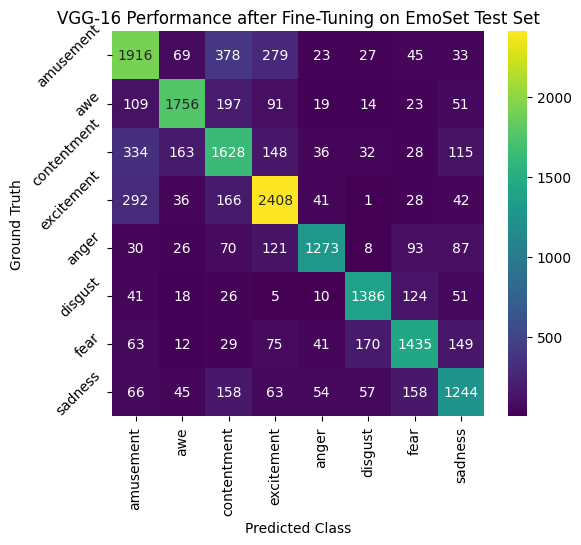

In [114]:
# Displays the confusion matrix and returns the classification report
emoset_test_metrics_dict = classifierEvaluationForEmoSet(
                                                all_test_true_labels,
                                                all_test_predicted_labels,
                                                "VGG-16 Performance after Fine-Tuning on EmoSet Test Set",
                                                average_type="macro",
                                                cmap="viridis"
)

### Evaluation of EmoSet Fine-Tuning Results

- While model performance is not perfect, with accuracy and macro F1-scores of 74%, this is decent for the task at hand for the following reasons.
- Only the classification, fully-connected layers were frozen and fine-tuned on the VGG-16 model in order to balance performance and computational efficiency, so this was a fairly decent result based on having to accommodate this trade-off
- Freezing lower layers of the model (i.e. the feature-extraction layers rather than modifying only the classification head of fully-connected linear dense layers) may have caused the VGG model to over-fit to the EmoSet dataset, when the final downstream task here is classifying the fake news vs real news images
- Recall and precision for the 8 emotion classes are similar, so there is no large precision-recall tradeoff here
- The confusion matrix shows that while for several emotion classes, there were quite a few wrong predictions, these predictions were generally between very similar emotions - e.g. "amusement" was frequently misclassified as "excitement" or "contentment", which seems logical, as the emotions themselves are on a similar spectrum. It would be more worrying if "amusement" were misclassified as "fear" or "sadnesss". Similarily, negative emotions such as "fear" and "sadness" were frequently confused, which is also to be expected. Emotions which **do not** have similar emotions in the eight classes, such as "disgust" or "anger" actually had an F1-score of about 80%, which is remarkably good performance for only fine-tuning the classification layers of the VGG-16 model.
- The overarching fake news detection architecture uses the *array* of softmaxed probabilities generated by the model as features, rather than single class labels extracted by using argmax functions. As such, this makes the features used for the final classification head more granular and allows the overall fake news model to capture more nuanced emotional constellations and distinctions. The outputted probabilities array could, for instance, contain relatively high probabilities for **both** fear *and* sadness, or both excitement and amusement, which allows the final classifier to learn more nuanced emotional patterns.

## Using the Pre-Trained EmoSet VGG-16 Model to get Image Predictions on the Fakeddit Multimodal Fake News Dataset

In [138]:
def getImagePredictions(news_sample, model, preprocessing):
    """
    Extracts emotion probabilities using the fine-tuned vgg-16 (on EmoSet) model from the Fakeddit images.
    
        Input Parameters:
            news_sample (dict): A sample containing the "image_path" with the relative path to the .jpg image file.
            model (torch.nn.Module): The fine-tuned VGG-16 model.
            preprocessing (torchvision.transforms.Compose): The preprocessing transformations to apply to the image.
        
        Output:
            dict: A dict containing the predicted probabilities for each emotion for this news sample's image.
    """
    image_path = news_sample["image_path"]
    
    # Tries to load the image, return a dict with None if it does not work
    try:
        # Tries to open the image and convert to RGBA and then RGB as before to avoid transparency error
        image = Image.open(image_path).convert("RGBA").convert("RGB")

        # Applies the transforms as before
        preprocessed_image = preprocessing(image)
        
        # Adds the batch dimension (1 [single_sample], num_channels [3], width [224], height[224])
        preprocessed_image = preprocessed_image.unsqueeze(0)
        
        # Places the image onto the correct device, should be the ssame as the model
        device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

        # Moves the image
        preprocessed_image = preprocessed_image.to(device)
        
        # Sets the model to feature extraction (non-training) mode
        model.eval()

        # No gradients as not training, just extracting features
        with torch.no_grad():

            # Gets model outputs
            outputs = model(preprocessed_image)
            
            # Applies the softmax function from the torch functional API to get the probabilities from logits for each possible emotion
            # This is a more fine-grained approach than using a single class label, as certain images can have different
            # emotions ascribed to them
            # Reference from the docs: https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html
            emotion_probabilities = F.softmax(outputs, dim=1)
        
        # Converts the probabilities to a NumPy array without the batch dimension, and return as a dict to add the key to Dataset object
        return {"emotion_probabilities": emotion_probabilities.squeeze().cpu().numpy()}
    
    except Exception as e:
        print(f"Could not open or process the image stored at {image_path}. Error: {e}!!!!")
        return {"emotion_probabilities": None} # Image was invalid, return None for this field

In [137]:
# Extracts each Dataset split from the loaded-in DatasetDict for all Fakeddit image and text data
train_dataset = filtered_fakeddit_vision_transformer_embeddings_dataset_dict["train"]
val_dataset = filtered_fakeddit_vision_transformer_embeddings_dataset_dict["val"]
test_dataset = filtered_fakeddit_vision_transformer_embeddings_dataset_dict["test"]

# Here, have copied and pasted the same image transforms as used in EmoSet.py for training the VGG-16 model
fakeddit_image_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

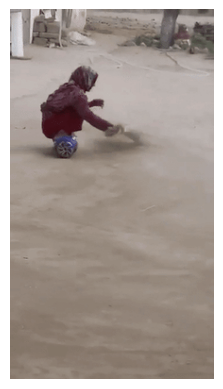

Probability array: [0.01478573 0.33493254 0.0705433  0.11334529 0.03199489 0.12182463
 0.04930275 0.26327077]
The main predicted emotion: awe


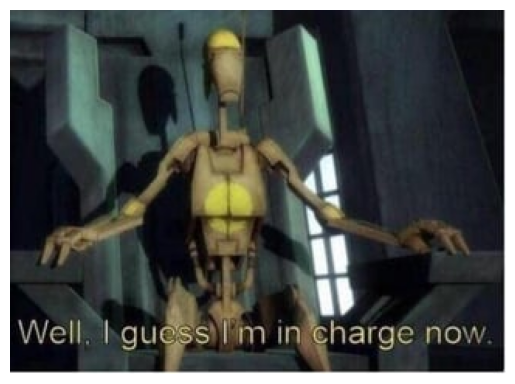

Probability array: [0.10133997 0.05334827 0.00659171 0.39548427 0.1491185  0.01319078
 0.2599157  0.02101076]
The main predicted emotion: excitement


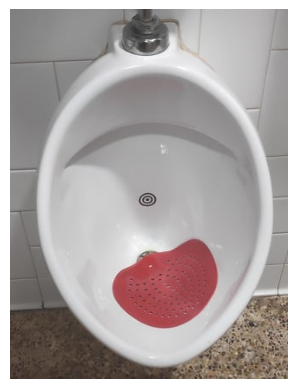

Probability array: [6.2748089e-02 4.7237845e-04 1.9763270e-01 4.9197266e-04 4.3255446e-04
 7.2678077e-01 1.0801839e-02 6.3981564e-04]
The main predicted emotion: disgust


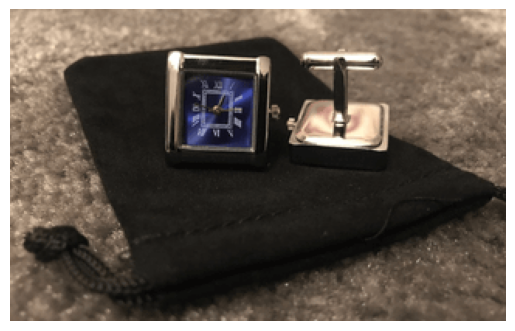

Probability array: [0.03173864 0.01248712 0.02458507 0.01295046 0.06258476 0.16216536
 0.4804974  0.21299122]
The main predicted emotion: fear


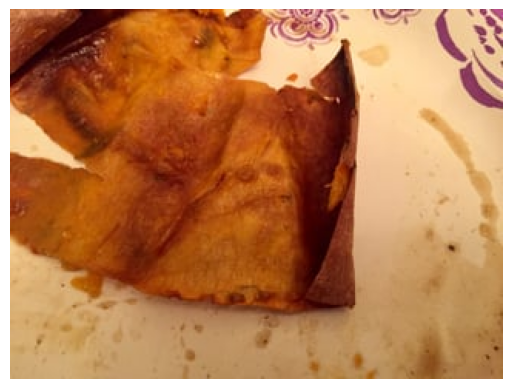

Probability array: [0.15386228 0.00275458 0.0979166  0.00076363 0.02427573 0.6020117
 0.09751906 0.02089637]
The main predicted emotion: disgust


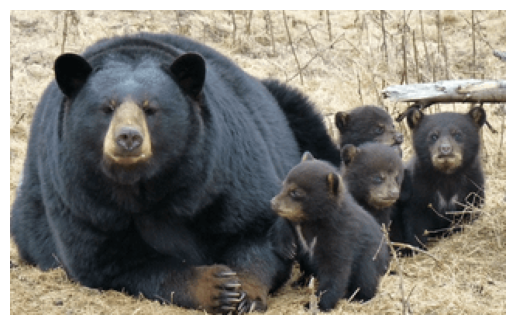

Probability array: [0.00277364 0.4313543  0.1065697  0.00224054 0.3210852  0.00113554
 0.01514068 0.11970035]
The main predicted emotion: awe


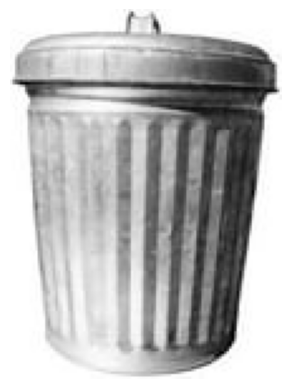

Probability array: [0.20275177 0.03324568 0.4030326  0.1043457  0.05205874 0.07138422
 0.08859252 0.04458871]
The main predicted emotion: contentment


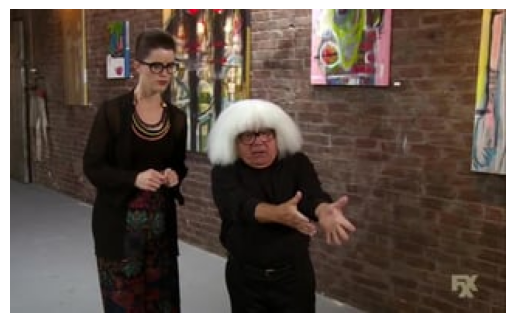

Probability array: [0.04991375 0.06897248 0.0187798  0.33199483 0.14685561 0.02501705
 0.32043102 0.0380354 ]
The main predicted emotion: excitement


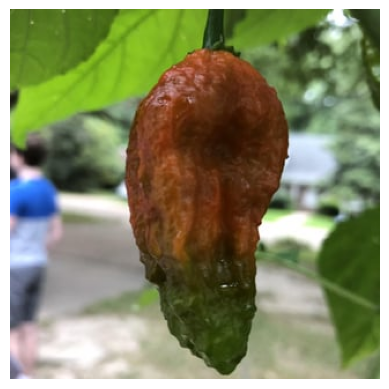

Probability array: [0.06683672 0.02565391 0.04881145 0.01611502 0.04973109 0.585779
 0.11319945 0.09387336]
The main predicted emotion: disgust


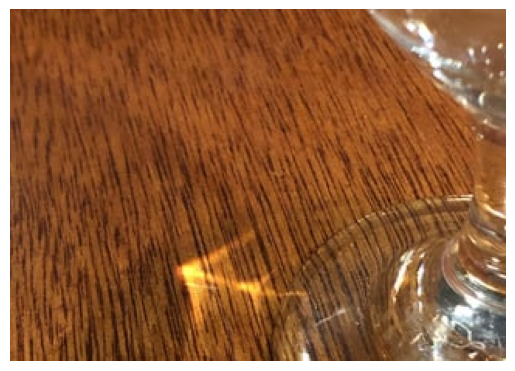

Probability array: [0.07015584 0.28008085 0.20418723 0.05503393 0.02512605 0.26219004
 0.06633192 0.03689422]
The main predicted emotion: awe


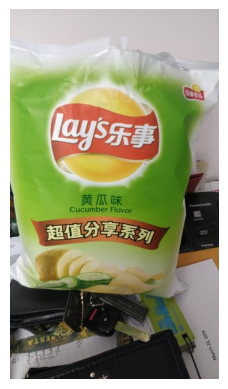

Probability array: [0.57529265 0.00796735 0.34824955 0.02629694 0.02173463 0.01337701
 0.00318599 0.00389583]
The main predicted emotion: amusement


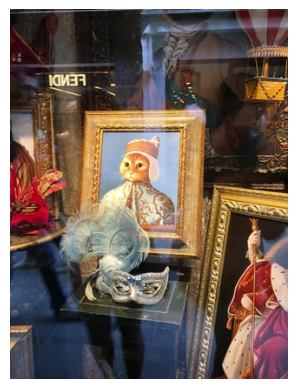

Probability array: [0.16411105 0.00398043 0.00126328 0.00402293 0.0104019  0.00083885
 0.80833167 0.00704992]
The main predicted emotion: fear


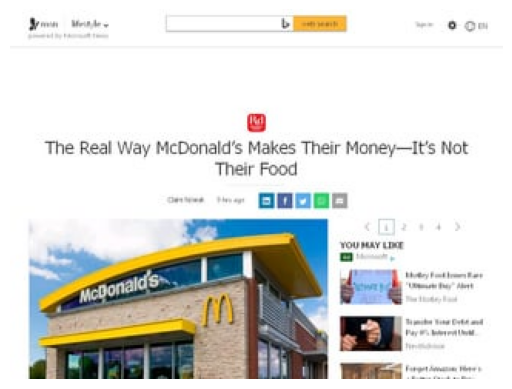

Probability array: [0.3853439  0.05129156 0.17929605 0.27210712 0.09503587 0.00469959
 0.003426   0.00879987]
The main predicted emotion: amusement


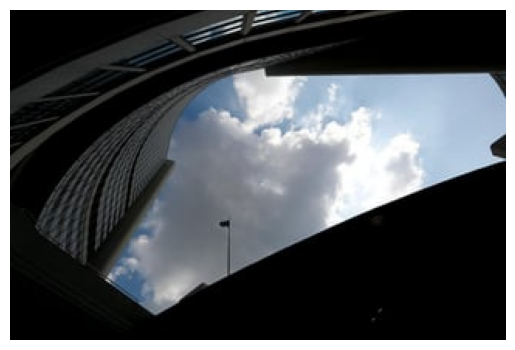

Probability array: [0.05293919 0.6953675  0.0221061  0.00466119 0.03896885 0.000829
 0.141461   0.04366709]
The main predicted emotion: awe


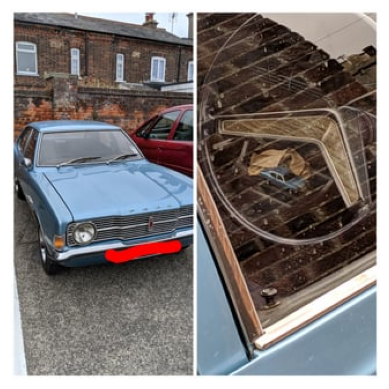

Probability array: [0.08566316 0.00612397 0.0093108  0.02766091 0.08193512 0.1562251
 0.11266145 0.5204195 ]
The main predicted emotion: sadness


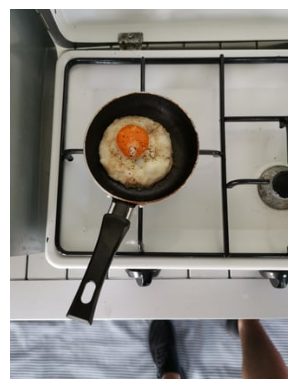

Probability array: [0.01086182 0.00077632 0.12374105 0.0105782  0.1490296  0.47521198
 0.09115959 0.13864145]
The main predicted emotion: disgust


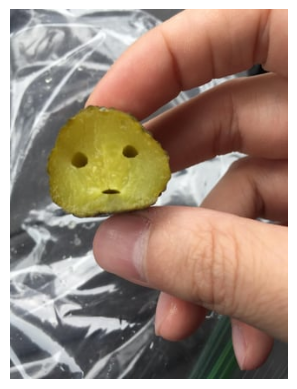

Probability array: [0.328632   0.00551595 0.3211899  0.0351104  0.00166169 0.26737455
 0.02373027 0.01678526]
The main predicted emotion: amusement


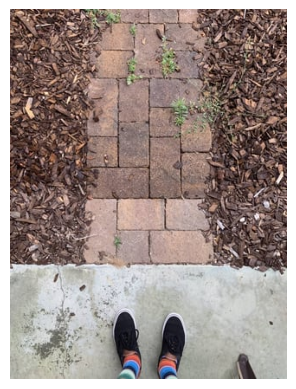

Probability array: [0.01038213 0.0089531  0.00584083 0.00494411 0.00874931 0.6476405
 0.06460737 0.24888258]
The main predicted emotion: disgust


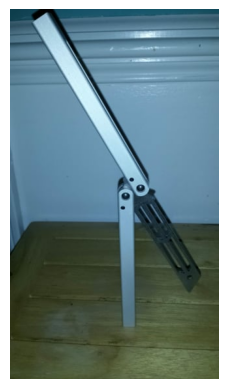

Probability array: [0.21518864 0.13508812 0.20080486 0.08952287 0.00587636 0.05295248
 0.17099729 0.12956943]
The main predicted emotion: amusement


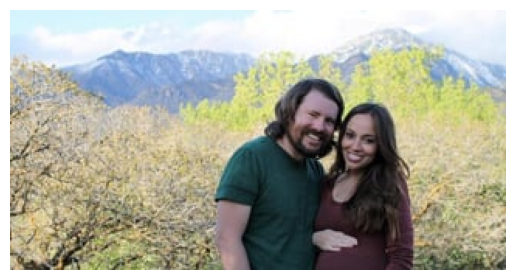

Probability array: [0.18896425 0.03095963 0.5033083  0.24539478 0.01634092 0.00085976
 0.00402463 0.01014778]
The main predicted emotion: contentment


In [178]:
# Checking the function works
counter = 0

# Iterates over the training images
for img in os.listdir("../../FPData/Fakeddit/Fakeddit_Image/train_images"):
    
    # Extracts the full image path
    img_path = os.path.join("../../FPData/Fakeddit/Fakeddit_Image/train_images", img)

    # Formats the image for input to getImagePredictions
    sample = {"image_path": img_path}
    
    # Displays the image
    pil_img = Image.open(img_path)
    plt.imshow(pil_img)
    plt.axis("off")
    plt.show()
    
    # Applies the prediction function with the pre-trained vgg-19 model
    predictions = getImagePredictions(sample, model, fakeddit_image_transforms["train"]) # Applies the train set transforms before prediction
    print(f"Probability array: {predictions['emotion_probabilities']}")
    
    # Gets the max emotion probability prediction
    pred_emo_idx = np.argmax(predictions["emotion_probabilities"])
    
    # Maps the 1st highest emotion index to the name using the dict defined above
    print(f"The main predicted emotion: {emotion_label2idx[pred_emo_idx]}")
    
    # Increments the loop counter to stop after testing 20 images samples
    counter += 1
    if counter == 20:
        break

In [194]:
# Now, applies the image processing and model inference function to the train, validation, and test datasets

# Train set
train_dataset = filtered_fakeddit_vision_transformer_embeddings_dataset_dict["train"].map(
    lambda sample: getImagePredictions(sample, model, fakeddit_image_transforms["train"])
)

In [195]:
# Validation set
val_dataset = filtered_fakeddit_vision_transformer_embeddings_dataset_dict["val"].map(
    lambda sample: getImagePredictions(sample, model, fakeddit_image_transforms["val"])
)

Map:   0%|          | 0/35470 [00:00<?, ? examples/s]

In [196]:
# Test set
test_dataset = filtered_fakeddit_vision_transformer_embeddings_dataset_dict["test"].map(
    lambda sample: getImagePredictions(sample, model, fakeddit_image_transforms["test"])
)

Map:   0%|          | 0/35873 [00:00<?, ? examples/s]

In [197]:
# Creates a new Fakeddit DatasetDict containing the train, val and test set and the new emotion probabilities
fakeddit_images_processed_dataset_dict = DatasetDict({
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset
})

In [201]:
# Use Datasets .filter method to remove rows where the image emotion probabilities embedding are None
filtered_fakeddit_images_processed_dataset_dict = fakeddit_images_processed_dataset_dict[.filter(
    lambda row: row["emotion_probabilities"] is not None
)

Filter:   0%|          | 0/332501 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35470 [00:00<?, ? examples/s]

Filter:   0%|          | 0/35873 [00:00<?, ? examples/s]

In [233]:
# Saves the filtered Fakeddit DatasetDict to disk
filtered_fakeddit_images_processed_dataset_dict.save_to_disk(
    "../../FPData/Fakeddit/Fakeddit_Image/fakeddit_with_processed_images_dict"
)

Saving the dataset (0/3 shards):   0%|          | 0/332501 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/35470 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/35873 [00:00<?, ? examples/s]

In [234]:
# Loads the filtered dataset with emotion probabilities back in
filtered_fakeddit_images_processed_dataset_dict = load_from_disk(
    "../../FPData/Fakeddit/Fakeddit_Image/fakeddit_with_processed_images_dict"
)
filtered_fakeddit_images_processed_dataset_dict.column_names

{'train': ['id',
  'num_comments',
  'score',
  'subreddit',
  'upvote_ratio',
  'label',
  'image_path',
  'cleaned_text_for_distilbert',
  '__index_level_0__',
  'cls_embedding',
  'emotion_probabilities'],
 'val': ['id',
  'num_comments',
  'score',
  'subreddit',
  'upvote_ratio',
  'label',
  'image_path',
  'cleaned_text_for_distilbert',
  '__index_level_0__',
  'cls_embedding',
  'emotion_probabilities'],
 'test': ['id',
  'num_comments',
  'score',
  'subreddit',
  'upvote_ratio',
  'label',
  'image_path',
  'cleaned_text_for_distilbert',
  '__index_level_0__',
  'cls_embedding',
  'emotion_probabilities']}

## Fusing ViT CLS Embedding Image Features with Emotion Probability Features

*From the original Yadav and Gupta paper*:

> **4.2 Experimental setup** <br>
In the multi-granular visual feature extraction module, the
images are normalized and resized to 224*224 size. The kernel size used in the Conv2D layer is 16*16. We use twelve
parallel attention heads, and the output of VGG-16 is taken
to get the image’s emotional features. Fully connected layer
of size 1024 is added for combining the multi-granular visual
features and visual emotions. In the contextual feature extraction, the size of the input text is set to 16. We use dropout
with a 0.4 value. The entire dataset is divided into training,
testing, and validation part with the split ratio of 80:10:10
with batch size 64, and we use K-fold validation testing to
test our datasets. For the Twitter dataset, the total epochs are
120 and the learning rate 0.001. For JFND, the total epochs
are 80 and the learning rate 0.001. For PFND and RFND,
the number of epochs 100 and learning rate 0.005. For
Fakeddit, the number of epochs are 100 and learning rate
0.004. All the experiments are performed in Python using
NVIDIA-Titan-RTX GPUs.

> -- <cite> Ashima Yadav and Anika Gupta. 2024. An emotion-driven, transformer-based network for multimodal fake news detection. International Journal of Multimedia Information Retrieval 13, 1 (2024). https://doi.org/10.1007/s13735-023-00315-3

In [236]:
def fuseImageFeatures(cls_embedding, emotion_probabilities, num_units=1024):

    """
    Fuses the each image's pre-traiened ViT transformer embedding features with emotion probabilities by concatenating
    and using a single fully-connected layer of size 1024.

        Inpput Parameters:
            cls_embedding (list of floats): the extracted CLS embedding for the image using pre-trained ViT transformer model
            emotion_probabilities (list of floats): the extracted emotion_probabilities list for an image, one probability
                                                    score for eight different emotions

        Output:
            outputs (torch.Tensor): a 1024-size Torch tensor combining ViT CLS image embeddings plus emo features
    """

    # Converts the CLS embeddings (numpy arrays) to PyTorch tensors
    cls_embedding = torch.tensor(cls_embedding)

    # Converts the emotion probability array to a tensor
    emotion_probabilities = torch.tensor(emotion_probabilities)

    # Concatenates the embeddings and probabilities into 1 one-dimensional tensor
    concat_features = torch.cat((cls_embedding, emotion_probabilities))

    # Creates the full-connected layer of size 1024 for combining visual features and visual emotions
    fully_connected_layer = torch.nn.Linear(concat_features.size(0), num_units)
    
    # Uses the functional torch API to apply the fully-connected layer to the concatenated features, followed by ReLu activation function
    outputs = F.relu(fully_connected_layer(concat_features))
    
    return outputs

In [240]:
# Fuses the CLS embeddings and emotion features for the training set
train_dataset = filtered_fakeddit_images_processed_dataset_dict["train"].map(
    lambda row: {
        "fused_img_features": fuseImageFeatures(
            row["cls_embedding"],
            row["emotion_probabilities"]
        )
    }
)

Map:   0%|          | 0/332501 [00:00<?, ? examples/s]

In [241]:
# Fuses the CLS embeddings and emotion features for the validation set
val_dataset = filtered_fakeddit_images_processed_dataset_dict["val"].map(
    lambda row: {
        "fused_img_features": fuseImageFeatures(
            row["cls_embedding"],
            row["emotion_probabilities"]
        )
    }
)

Map:   0%|          | 0/35470 [00:00<?, ? examples/s]

In [242]:
# Fuses the CLS embeddings and emotion features for the test set
test_dataset = filtered_fakeddit_images_processed_dataset_dict["test"].map(
    lambda row: {
        "fused_img_features": fuseImageFeatures(
            row["cls_embedding"],
            row["emotion_probabilities"]
        )
    }
)

Map:   0%|          | 0/35873 [00:00<?, ? examples/s]

In [249]:
# Creates a new Fakeddit DatasetDict containing the fused image embeddings
fakeddit_finished_processing_images_dataset_dict = DatasetDict({
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset
})

In [251]:
# Saves the dataset with images now pre-processed for training
fakeddit_finished_processing_images_dataset_dict.save_to_disk(
    "../../FPData/Fakeddit/Fakeddit_Image/fakeddit_images_done_dataset_dict"
)

Saving the dataset (0/5 shards):   0%|          | 0/332501 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/35470 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/35873 [00:00<?, ? examples/s]

In [25]:
# Loads the dataset with images now pre-processed for training
fakeddit_finished_processing_images_dataset_dict = load_from_disk(
    "../../FPData/Fakeddit/Fakeddit_Image/fakeddit_images_done_dataset_dict"
)

## Extracting DistilBERT Text Embeddings as Before

In [26]:
# Loads in the DistilBERT model
model_ckpt = "distilbert-base-uncased"

# Loads in the pre-trained DistilBERT tokenizer
distilbert_tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Loads in the the DistilBERT model
distilbert_model = AutoModel.from_pretrained(model_ckpt)

In [27]:
def encodeText(text, tokenizer, model):
    """
        Uses PyTorch and pre-trained DistilBERT model for CLS feature extraction of news texts.
        
            Input Parameters:
                text (str): the text to encode into the pre-trained DistilBERT embeddings
                tokenizer (transformers.models.distilbert.tokenization_distilbert_fast.DistilBertTokenizerFast): the DistilBERT autotokenizer
                model (transformers.models.distilbert.modeling_distilbert.DistilBertModel): DistilBERT model for generating embeddings
                
            Output:
                encoding (torch.Tensor): CLS summary embeddings of the text using the DistilBERT tokenizer
    """
    # Uses the tokenizer to encode the text
    tokenizer_encoding = tokenizer.encode_plus(
                                        text, # The texts to be encoded
                                        max_length=25, # Based on previous analysis, max length of Fakeddit texts is under 25
                                        truncation=True,
                                        padding="max_length",
                                        add_special_tokens=True, # Adds [CLS] token which stores text info for classification tasks
                                        return_attention_mask=True, # Returns the attention mask to show which tokens are padded
                                        return_token_type_ids=False, # Not necessary for DistilBERT
                                        return_tensors="pt" # Return PyTorch (instead of TensorFlow) tensors
    )

    # Gets the input ids from tokenization ioutoput
    input_ids = tokenizer_encoding["input_ids"]

    # Extracts the attention mask
    attention_mask = tokenizer_encoding["attention_mask"]
    
    # Reference: p. 40 of NLP with Transformers book by Tunstall et al.
    """
        --> Looking at the hidden state tensor, we see that it has the shape [batch_size,
        n_tokens, hidden_dim]. In other words, a 768-dimensional vector is returned for
        each of the n_tokens (here: 25) input tokens. 
    """
    with torch.no_grad():  # Disables the training gradients to save memory and computation, not needed for feature extraction
        outputs = model(input_ids, attention_mask=attention_mask) # Generates the model outputs (embeddings per token)
    
    last_hidden_state = outputs.last_hidden_state # Gets the last hidden state (last embeddings) generated by DistilBERT

    """
        --> "For classification tasks, it is common practice to just use
        the hidden state associated with the [CLS] token as the input feature." 
        
        --> "Since this token appears at the start of each sequence, we can extract it by simply indexing into
        outputs.last_hidden_state as follows (Tunstall et al. book)"
    """
    cls_hidden_state = last_hidden_state[:, 0, :] # Extracts only the first token embedding for [num_samples, num_tokens, embedding_size]

    # Removes the batch (of size 1) dimension to return a 1-dimensional tensor of length 768 values
    cls_hidden_state = cls_hidden_state = cls_hidden_state.squeeze(0)
    
    return cls_hidden_state

In [28]:
# Applies the DistilBERT embedding extraction to the training set
train_dataset = fakeddit_finished_processing_images_dataset_dict["train"].map(
    lambda row: {
        "distilbert_embedding": encodeText(row["cleaned_text_for_distilbert"], distilbert_tokenizer, distilbert_model)
    }
)

Map:   0%|          | 0/332501 [00:00<?, ? examples/s]

In [29]:
# Applies the DistilBERT embedding extraction to the validation set
val_dataset = fakeddit_finished_processing_images_dataset_dict["val"].map(
    lambda row: {
        "distilbert_embedding": encodeText(row["cleaned_text_for_distilbert"], distilbert_tokenizer, distilbert_model)
    }
)

Map:   0%|          | 0/35470 [00:00<?, ? examples/s]

In [30]:
# Applies the DistilBERT embedding extraction to the test set
test_dataset = fakeddit_finished_processing_images_dataset_dict["test"].map(
    lambda row: {
        "distilbert_embedding": encodeText(row["cleaned_text_for_distilbert"], distilbert_tokenizer, distilbert_model)
    }
)

Map:   0%|          | 0/35873 [00:00<?, ? examples/s]

In [31]:
# Creates a new Fakeddit DatasetDict containing the DistilBERT embeddings
fakeddit_with_distilbert_embeddings_dataset_dict = DatasetDict({
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset
})

In [32]:
# Saves the dataset with DistilBERT embeddings now pre-processed for training
fakeddit_with_distilbert_embeddings_dataset_dict.save_to_disk(
    "../../FPData/Fakeddit/Fakeddit_Image/distilbert_done_dataset_dict"
)

Saving the dataset (0/7 shards):   0%|          | 0/332501 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/35470 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/35873 [00:00<?, ? examples/s]

In [33]:
# Loads the dataset with DistilBERT embeddings now pre-processed for training
fakeddit_with_distilbert_embeddings_dataset_dict = load_from_disk(
    "../../FPData/Fakeddit/Fakeddit_Image/distilbert_done_dataset_dict"
)

fakeddit_with_distilbert_embeddings_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['id', 'num_comments', 'score', 'subreddit', 'upvote_ratio', 'label', 'image_path', 'cleaned_text_for_distilbert', '__index_level_0__', 'cls_embedding', 'emotion_probabilities', 'fused_img_features', 'distilbert_embedding'],
        num_rows: 332501
    })
    val: Dataset({
        features: ['id', 'num_comments', 'score', 'subreddit', 'upvote_ratio', 'label', 'image_path', 'cleaned_text_for_distilbert', '__index_level_0__', 'cls_embedding', 'emotion_probabilities', 'fused_img_features', 'distilbert_embedding'],
        num_rows: 35470
    })
    test: Dataset({
        features: ['id', 'num_comments', 'score', 'subreddit', 'upvote_ratio', 'label', 'image_path', 'cleaned_text_for_distilbert', '__index_level_0__', 'cls_embedding', 'emotion_probabilities', 'fused_img_features', 'distilbert_embedding'],
        num_rows: 35873
    })
})

## Extracting the Textual Emotion and Extra Engineered Features for Each Multimodal Row using Pre-Saved DataFrames

In [34]:
# Loads in the Fakeddit feature DataFrames
fe_emotions_emojis_train_df = pd.read_csv("../../FPData/EmotionApproach/fe_nrc_emotions_emojis_scores_train_df.csv")
fe_emotions_emojis_val_df = pd.read_csv("../../FPData/EmotionApproach/fe_nrc_emotions_emojis_scores_val_df.csv") 
fe_emotions_emojis_test_df = pd.read_csv("../../FPData/EmotionApproach/fe_nrc_emotions_emojis_scores_test_df.csv")

# Lists the extra feature columns
all_feature_columns = [
    "nrc_anger_emotion_score", "nrc_anticipation_emotion_score", 
    "nrc_disgust_emotion_score", "nrc_fear_emotion_score", 
    "nrc_joy_emotion_score", "nrc_positive_emotion_score", 
    "nrc_negative_emotion_score", "nrc_sadness_emotion_score", 
    "nrc_surprise_emotion_score", "nrc_trust_emotion_score", 
    "emoji_based_sent_score", "exclamation_point_frequency", "third_person_pronoun_frequency", 
    "noun_to_verb_ratio", "cardinal_named_entity_frequency", 
    "person_named_entity_frequency", "difficult_words_readability_score", 
    "capital_letter_frequency", "flesch_kincaid_readability_score"
]

# Lists the extra emotion and other feature columns to extract that have been pre-saved in the DataFrames
emotion_feature_columns = [ 
    "nrc_anger_emotion_score", "nrc_anticipation_emotion_score", 
    "nrc_disgust_emotion_score", "nrc_fear_emotion_score", 
    "nrc_joy_emotion_score", "nrc_positive_emotion_score", 
    "nrc_negative_emotion_score", "nrc_sadness_emotion_score", 
    "nrc_surprise_emotion_score", "nrc_trust_emotion_score", 
    "emoji_based_sent_score"
]

# Lists only the non-emotion extra engineered feature column names
extra_feature_columns = [
    "exclamation_point_frequency", "third_person_pronoun_frequency", 
    "noun_to_verb_ratio", "cardinal_named_entity_frequency", 
    "person_named_entity_frequency", "difficult_words_readability_score", 
    "capital_letter_frequency", "flesch_kincaid_readability_score"
]

# Creates dictionaries based on ID for each DataFrame row, using only the extracted feature columns
# 1. Change the index of each DataFrame to the "id" column
# 2. Extract the extra feature columns
# 3. Change extracted columns with index "id" to a dictionary
# 4. Set the "id" i.e. Index to be the main key in the dictionary, with columns and values as sub-dictionaries for each id row
# Reference: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_dict.html
train_df_dict = fe_emotions_emojis_train_df.set_index("id")[all_feature_columns].to_dict(orient="index")
val_df_dict = fe_emotions_emojis_val_df.set_index("id")[all_feature_columns].to_dict(orient="index")
test_df_dict = fe_emotions_emojis_test_df.set_index("id")[all_feature_columns].to_dict(orient="index")

In [221]:
# Checks the keys in the dict are news sample IDs
print(list(train_df_dict.keys())[0:20])
# Checks the sub-dict contains feature columns and their values
print("\n")
print(f"Example dict: {train_df_dict['796d3z']}")

['awxhir', '98pbid', '6f2cy5', 'bo5i67', '4xypkv', '8gnet9', '71lejc', '2vkbtj', '6d50rl', '86byl8', '98vrcq', '1pulau', 'bmg5cj', '4zd1tb', '3n5a0t', '9g2b4h', '796d3z', '2nedlq', '3qlikw', '2cfi7g']


Example dict: {'nrc_anger_emotion_score': 0.0, 'nrc_anticipation_emotion_score': 0.1666666666666666, 'nrc_disgust_emotion_score': 0.0, 'nrc_fear_emotion_score': 0.0, 'nrc_joy_emotion_score': 0.3333333333333333, 'nrc_positive_emotion_score': 0.3333333333333333, 'nrc_negative_emotion_score': 0.0, 'nrc_sadness_emotion_score': 0.0, 'nrc_surprise_emotion_score': 0.0, 'nrc_trust_emotion_score': 0.1666666666666666, 'emoji_based_sent_score': 0.0, 'exclamation_point_frequency': 0.0, 'third_person_pronoun_frequency': 0.0526315789473684, 'noun_to_verb_ratio': 1.25, 'cardinal_named_entity_frequency': 0.0, 'person_named_entity_frequency': 0.0, 'difficult_words_readability_score': 2, 'capital_letter_frequency': 0.1578947368421052, 'flesch_kincaid_readability_score': 5.6}


In [3]:
def extractTextFeaturesFromNewsSample(news_sample, features_dict, emotion_feature_columns, extra_feature_columns):
    """
        Extracts the pre-calculated textual (emotion and other engineered) features to new fields in the 
        train/validation/test Dataset objects

            Input Parameters:
                news_sample: the Dataset row containing id, DistilBERT embedding, image features and other attributes of 
                             a specific news sample
                features_dict (dict): the dict containing all the scores for extracted features (e.g. NRC emotion lexicon scores) that were
                                      previous saved to disk, for all train, validation, or test smaples
                emotion_feature_columns (list): the list of names of emotion feature keys/columns
                extra_feature_columns (list): the list of names of the extra eng. features
    
            Output:
                dict: a dictionary containing the scores for the emotion features for the news text and the extra engineered features
    """

    # Extracts the id field from news sample
    news_id = news_sample["id"]

    # Extracts the correct sub-dict storing all textual features for this news sample based on the main ID key. 
    # Returns an empty dict if not found
    feature_values = features_dict.get(news_id, {})
    
    # Creates a new dict for textual emotion features of this news sample, with the
    # emotion features as the keys and their scores as values
    textual_emotion_features = {key: feature_values.get(key) for key in emotion_feature_columns}
    
    # Does the same as above but for the extra engineered (non-emotion) features
    textual_extra_features = {key: feature_values.get(key) for key in extra_feature_columns}
    
    # Returns the two new attributes for this news text
    return {
        "textual_emotion_features": textual_emotion_features,
        "textual_extra_features": textual_extra_features
    }

In [36]:
# Applies the feature extraction function to the train/validation/test sets

# Training set
train_dataset = fakeddit_with_distilbert_embeddings_dataset_dict["train"].map(
    lambda news_sample: extractTextFeaturesFromNewsSample(news_sample, train_df_dict, emotion_feature_columns, extra_feature_columns)
)

Map:   0%|          | 0/332501 [00:00<?, ? examples/s]

In [37]:
# Validation set
val_dataset = fakeddit_with_distilbert_embeddings_dataset_dict["val"].map(
    lambda news_sample: extractTextFeaturesFromNewsSample(news_sample, val_df_dict, emotion_feature_columns, extra_feature_columns)
)

Map:   0%|          | 0/35470 [00:00<?, ? examples/s]

In [38]:
# Test set
test_dataset = fakeddit_with_distilbert_embeddings_dataset_dict["test"].map(
    lambda news_sample: extractTextFeaturesFromNewsSample(news_sample, test_df_dict, emotion_feature_columns, extra_feature_columns)
)

Map:   0%|          | 0/35873 [00:00<?, ? examples/s]

In [39]:
# Creates a new Fakeddit DatasetDict containing the emotion and extra features
fakeddit_with_feature_dicts = DatasetDict({
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset
})

In [40]:
def concatenateExtraFeaturesAsList(news_sample, emotion_feature_columns, extra_feature_columns):
    """
        Extracts all the emotion and extra features values and puts them in one list

        Input Parameters:
            news_sample (dict): the news sample with the text, label, and extracted embeddings/features so far from the HuggingFace Dataset
            emotion_feature_columns (list): list of emotion feature column/key names
            extra_feature_columns (list):  list of extra engineered feature column/key names

        Output:
            dict: a dictionary storing the concatenated emotion and extra text features (e.g. readability scores)
    """
    
    # Converts the emotion features from dict values to list. Returns 0.0 if feature name not found in dict keys
    emo_features = [news_sample["textual_emotion_features"].get(feature_name, 0.0) for feature_name in emotion_feature_columns]
    
    # Converts the other text features from dictionary vals to list
    extra_features = [news_sample["textual_extra_features"].get(feature_name, 0.0) for feature_name in extra_feature_columns]

    # Concatenates the two features lists
    concat_features = emo_features + extra_features
    return {
        "extra_text_features_list": concat_features
    }

In [41]:
# Concatenates the sets of extra textual features features as a list
train_dataset = fakeddit_with_feature_dicts["train"].map(
    lambda news_sample: concatenateExtraFeaturesAsList(news_sample, emotion_feature_columns, extra_feature_columns)
)

Map:   0%|          | 0/332501 [00:00<?, ? examples/s]

In [42]:
# Validation set
val_dataset = fakeddit_with_feature_dicts["val"].map(
    lambda news_sample: concatenateExtraFeaturesAsList(news_sample, emotion_feature_columns, extra_feature_columns)
)

Map:   0%|          | 0/35470 [00:00<?, ? examples/s]

In [43]:
# Test set
test_dataset = fakeddit_with_feature_dicts["test"].map(
    lambda news_sample: concatenateExtraFeaturesAsList(news_sample, emotion_feature_columns, extra_feature_columns)
)

Map:   0%|          | 0/35873 [00:00<?, ? examples/s]

In [44]:
# Creates a new Fakeddit DatasetDict containing the concatenated lists of emotion and extra features
fakeddit_with_feature_lists = DatasetDict({
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset
})

fakeddit_with_feature_lists

DatasetDict({
    train: Dataset({
        features: ['id', 'num_comments', 'score', 'subreddit', 'upvote_ratio', 'label', 'image_path', 'cleaned_text_for_distilbert', '__index_level_0__', 'cls_embedding', 'emotion_probabilities', 'fused_img_features', 'distilbert_embedding', 'textual_emotion_features', 'textual_extra_features', 'extra_text_features_list'],
        num_rows: 332501
    })
    val: Dataset({
        features: ['id', 'num_comments', 'score', 'subreddit', 'upvote_ratio', 'label', 'image_path', 'cleaned_text_for_distilbert', '__index_level_0__', 'cls_embedding', 'emotion_probabilities', 'fused_img_features', 'distilbert_embedding', 'textual_emotion_features', 'textual_extra_features', 'extra_text_features_list'],
        num_rows: 35470
    })
    test: Dataset({
        features: ['id', 'num_comments', 'score', 'subreddit', 'upvote_ratio', 'label', 'image_path', 'cleaned_text_for_distilbert', '__index_level_0__', 'cls_embedding', 'emotion_probabilities', 'fused_img_featur

In [45]:
# Saves the dataset with textual features
fakeddit_with_feature_lists .save_to_disk(
    "../../FPData/Fakeddit/Fakeddit_Image/fakeddit_with_feature_lists"
)

Saving the dataset (0/8 shards):   0%|          | 0/332501 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/35470 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/35873 [00:00<?, ? examples/s]

In [46]:
# Loads the dataset back in 
fakeddit_with_feature_lists  = load_from_disk(
    "../../FPData/Fakeddit/Fakeddit_Image/fakeddit_with_feature_lists"
)

In [48]:
# OLD CODE - removed, do not use (forgot to scale the features)

# def concatenateFeatures(news_sample):
#     """
#         Concatenates the fused image feature array with the DistilBERT embedding and extra emotion/other features for one sample.
            
#         Input Parameters:
#             news_sample (dict): the news sample with the text, label, and extracted embeddings/features so far from the HuggingFace Dataset

#         Output:
#             dict: a dictionary storing a concatenated list of: 1. The 1024-length fused image features 2. The DistilBERT embedding
#             3. The extra features list
#     """

#     # Converts to tensors
#     fused_img_features_tensor = torch.tensor(news_sample["fused_img_features"], dtype=torch.float32)
#     distilbert_embedding_tensor = torch.tensor(news_sample["distilbert_embedding"], dtype=torch.float32)
#     extra_text_features_tensor = torch.tensor(news_sample["extra_text_features_list"], dtype=torch.float32)

#     # Concatenates the 1D feature tensors into long rows of all the features
#     concat_features = torch.cat([fused_img_features_tensor, distilbert_embedding_tensor, extra_text_features_tensor])

#     return {"concat_features": concat_features.tolist()}  # Converts back to list to go back into HF Dataset object

# # Applies the feature concatenation function to the training set
# fakeddit_with_feature_lists["train"] = fakeddit_with_feature_lists["train"].map(concatenateFeatures)

# # Applies the feature concatenation function to the val set
# fakeddit_with_feature_lists["val"] = fakeddit_with_feature_lists["val"].map(concatenateFeatures)

# # Applies the feature concatenation function to the test set
# fakeddit_with_feature_lists["test"] = fakeddit_with_feature_lists["test"].map(concatenateFeatures)

# # Save the dataset with all of the not-yet scaled concatnated features, ready for trainig
# fakeddit_with_feature_lists.save_to_disk(
#     "../../FPData/Fakeddit/Fakeddit_Image/fakeddit_ready_non_scaled"
# )

# # Loads the dataset back in, ready for training the final model except for scaling
# fakeddit_with_feature_lists  = load_from_disk(
#     "../../FPData/Fakeddit/Fakeddit_Image/fakeddit_ready_non_scaled"
# )

# def concatenateEmotionFeaturesOnly(news_sample):

#     # Converts the fused image features and DistilBERT embeddings to tensors
#     fused_img_features_tensor = torch.tensor(news_sample["fused_img_features"], dtype=torch.float32)
    
#     distilbert_embedding_tensor = torch.tensor(news_sample["distilbert_embedding"], dtype=torch.float32)
    
#     # Extracts only the emotion values, not the other extra features, and converts to tensor
#     extra_text_features_tensor = torch.tensor(news_sample["extra_text_features_list"][0:11], dtype=torch.float32)

#     # Concatenates the 1D feature tensors into long rows of all the features
#     concat_features = torch.cat([fused_img_features_tensor, distilbert_embedding_tensor, extra_text_features_tensor])

#     return {"concat_emotion_features": concat_features.tolist()}  # Convert back to list to go into HF Dataset object

# # Applies the feature concatenation function to the training set
# fakeddit_with_feature_lists["train"] = fakeddit_with_feature_lists["train"].map(concatenateEmotionFeaturesOnly)

# # Applies the feature concatenation function to the val set
# fakeddit_with_feature_lists["val"] = fakeddit_with_feature_lists["val"].map(concatenateEmotionFeaturesOnly)

# # Applies the feature concatenation function to the test set
# fakeddit_with_feature_lists["test"] = fakeddit_with_feature_lists["test"].map(concatenateEmotionFeaturesOnly)

# # Saves the dataset with all of the not-yet scaled concatnated features, ready for trainig
# fakeddit_with_feature_lists.save_to_disk(
#     "../../FPData/Fakeddit/Fakeddit_Image/fakeddit_ready_concat_emo_features"
# )

# # Loads the dataset back in, ready for training the final model except for scaling
# fakeddit_with_feature_lists  = load_from_disk(
#     "../../FPData/Fakeddit/Fakeddit_Image/fakeddit_ready_concat_emo_features"
# )

# fakeddit_with_feature_lists

## Scaling Extra Text (Emotion and Linguistic/Semantic) Features to Be in Same Range as DistilBERT Embeddings

In [12]:
def scaleExtraTextFeatures(dataset):
    """
        Scales the  extra text features to be in the same range as the DistilBERT floating-point embedding values, using
        the scikit-learn MinMaxScaler.

        Input Parameters:
            dataset (datasets.arrow_dataset.Dataset): the train/val/test dataset with "extra_text_features_list" column to scale to DistilBERT ranges

        Output:
            scaled_features (list of lists): lists of scaled text features (emotion and other ling. features) per sample n dataset
            
    """
    
    # Extracts the extra text features, converts the list-of-lists to numpy array
    extra_features = np.array(dataset["extra_text_features_list"])
    
    # Extracts the DistilBERT features 
    distilbert_embeddings = np.array(dataset["distilbert_embedding"])

    # Use vstack to ensure the correct shape of the numpy array, ensures that each row represents the features for a single news sample
    extra_features = np.vstack(extra_features)
    distilbert_embeddings = np.vstack(distilbert_embeddings)

    # Calculates the minimum and maximum values of each CLS embedding-value column from the DistilBERT embedding columns (axis = 0)
    min_values = distilbert_embeddings.min(axis = 0)
    max_values = distilbert_embeddings.max(axis = 0)

    # Initializes a MinMaxScaler and sets the range from the min DistilBERT value to the max DistilBERT value from all the embed. vals.
    scaler = MinMaxScaler(feature_range=(min_values.min(), max_values.max()))

    # Fits the scaler to the extra features array
    scaler.fit(extra_features)

    # Transforms the extra_text_features_list for storing in the Dataset object
    scaled_features = scaler.transform(extra_features).tolist()

    # Return the scaled features
    return scaled_features

In [5]:
# Applies the scaling function to extra text features in the three dataset splits
train_text_feats_scaled = scaleExtraTextFeatures(fakeddit_with_feature_lists["train"])
val_text_feats_scaled = scaleExtraTextFeatures(fakeddit_with_feature_lists["val"])
test_text_feats_scaled = scaleExtraTextFeatures(fakeddit_with_feature_lists["test"])

In [6]:
def addScaledFeaturesToDataset(sample, idx, scaled_features):
    """
        Input Parameters:
            sample (dict): news set sample
            idx (int): index of the news sample in the dataset
            scaled_features (NumPy nd.array): scaled features array

        Output:
            sample (dict): news sample with the extra scaled features
    """
    
    sample["scaled_extra_text_features"] = scaled_features[idx] # Extracts the scaled features for the index and set to new column
    return sample

# Updates the datasets with the scaled features in the "scaled_extra_text_features" column
fakeddit_with_feature_lists["train"] = fakeddit_with_feature_lists["train"].map(
    # Uses the sample indices to select the correct row of scaled features
    lambda news_sample, index: addScaledFeaturesToDataset(news_sample, index, train_text_feats_scaled), with_indices=True 
)

In [7]:
# Applies the feature scaling function to the validation set
fakeddit_with_feature_lists["val"] = fakeddit_with_feature_lists["val"].map(
    lambda news_sample, index: addScaledFeaturesToDataset(news_sample, index, val_text_feats_scaled), with_indices=True
)

In [8]:
# Applies the feature scaling function to the test set
fakeddit_with_feature_lists["test"] = fakeddit_with_feature_lists["test"].map(
    lambda news_sample, index: addScaledFeaturesToDataset(news_sample, index, test_text_feats_scaled), with_indices=True
)

In [17]:
# Saves the dataset with all of the not-yet scaled concatnated features, ready for trainig
fakeddit_with_feature_lists.save_to_disk(
    "../../FPData/Fakeddit/Fakeddit_Image/fakeddit_scaled_text_features"
)

In [16]:
# # Loads the dataset back in, ready for training the final model except for scaling
fakeddit_with_feature_lists  = load_from_disk(
    "../../FPData/Fakeddit/Fakeddit_Image/fakeddit_scaled_text_features"
)

## Fusing the Scaled Text Features with DistilBERT embeddings using a Fully-Connected Layer (as for the image features and embeddings)

In [18]:
def fuseTextFeatures(input_tensor, input_size, hidden_size, output_size, device):
    """
    A simple fusion function using a linear layer of size 1024 for fusing DistilBERT embeddings and extra textual features,
    just like for the image transformer CLS and image emo features and as specified in the Yadav & Gupta paper.

        Input Parameters:
            input_tensor (torch.Tensor): a concatenated DistilBERT CLS embeddings plus extra features tensor
            input_size (int): the size of each sample's tensor (should be 787 for CLS embedding size of 768 + 19 feats)
            hidden_size (int): the number of hidden layer units in the fusing fully-connected layer (1024)
            output_size (int): the size/dimension of the output vectors for each sample (1024)
            device (torch.device): the device to do operations on, should be MPS for accelerated performance 

        Output:
            output3 (torch.device): the device to do operations on, should be MPS for accelerated performance 
    """
    
    # Defines the sequential fully-connected PyTorch layers

    # Input layer
    layer1 = torch.nn.Linear(input_size, hidden_size).to(device)  # Moves layer1 to the (MPS) device
    relu = torch.nn.ReLU() # Adds ReLu activation function

    # Output layer of 1024 hidden units
    layer2 = torch.nn.Linear(hidden_size, output_size).to(device)  # Moves layer2 to the (MPS) device

    # Adds the first input layer to the model
    output1 = layer1(input_tensor)

    # Applies the ReLU activation function
    output2 = relu(output1)

    # Applies the second hidden unit fully-connected layer to get the final fused textual features
    output3 = layer2(output2)

    return output3


def addFusedTextFeaturesToDataset(news_sample, index, fused_features):
    """
    Adds the fused text features to the sample in the dataset at the specified index.

        Input Parameters: 
            news_sample (dict): the HuggingFace Dataset single news sample to extract fused features for
            index (int): the sample's index in the Dataset/fused features NumPy array
            fused_features (numpy.ndarray): the 2D array storing fused feature arrays of shape (num_samples, vector_dimension_size)

        Output:
            sample_copy (dict): the news sample now with the fused_features key-value pair added in
    """
    
    # Makes a copy of the sample to not modify the original
    sample_copy = news_sample.copy()  
    
    # Assigns the correct fused features row to the sample at this index
    sample_copy["fused_text_features"] = fused_features[index]  
    return sample_copy


def processTextFeatures(dataset, device, input_size=787, hidden_size=1024, output_size=1024):
    """
    Concatenates and fuses extra text features with DistilBERT embeddings for the entire dataset.

        Input Parameters:
            dataset (datasets.Dataset): the HuggingFace Dataset object to fuse embeddings and features for
            device (torch.device): the device to do operations on, should be MPS for accelerated performance 
            input_size (int): concatenated embedding plus feature vector dimension (default 787)
            hidden_size (int): number of hidden units in fully-connected fusion layer (default 1024)
            output_size (int): the output sample vector dimension (default 1024)
            
        Output:
            dataset (datasets.Dataset): the HuggingFace Dataset object with fused DistilBERT embeddings and extra text features
        
    """

    # Extracts the distilbert_embeddings field (shape: num_samples, 768) and scaled_extra_text_features (shape: num_samples, 19)
    distilbert_embeddings = np.array(dataset["distilbert_embedding"])  # Shape: (num_samples, 768)
    scaled_extra_features = np.array(dataset["scaled_extra_text_features"])  # Shape: (num_samples, 19)

    # Converts the arrays to PyTorch tensors for fusion
    distilbert_tensor = torch.tensor(distilbert_embeddings, dtype=torch.float32).to(device)
    scaled_extra_tensor = torch.tensor(scaled_extra_features, dtype=torch.float32).to(device)

    # Concatenates both tensors along the feature axis, not the "num_samples" axis (resulting in shape: num_samples, 787)
    concat_tensor = torch.cat((distilbert_tensor, scaled_extra_tensor), dim=1)

    # Fuses the concatenated features with the above function
    fused_text_features_output = fuseTextFeatures(concat_tensor, input_size, hidden_size, output_size, device)

    # Converts the outputted 1024-unit tensor to NumPy format
    fused_text_features_np_array = fused_text_features_output.detach().cpu().numpy()

    # Uses "map" with progress bar to add the fusde text features to the HuggingFace dataset
    dataset = dataset.map(lambda news_sample, index: addFusedTextFeaturesToDataset(news_sample, index, fused_text_features_np_array), 
                          with_indices=True, 
                          desc="Processing Dataset", 
                          num_proc=4) # Speed up the processing here

    return dataset

In [21]:
# Moves computation to MPS
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Gets the fused features for the training Dataset
fakeddit_with_feature_lists["train"] = processTextFeatures(fakeddit_with_feature_lists["train"], device)

In [20]:
# Gets the fused features for the validation dataset
fakeddit_with_feature_lists["val"] = processTextFeatures(fakeddit_with_feature_lists["val"], device)

# Gets the fused features for the test Dataset
fakeddit_with_feature_lists["test"] = processTextFeatures(fakeddit_with_feature_lists["test"], device)

Processing Dataset (num_proc=4):   0%|          | 0/35470 [00:00<?, ? examples/s]

Processing Dataset (num_proc=4):   0%|          | 0/35873 [00:00<?, ? examples/s]

In [22]:
# Checks if the "fused_text_features" field is present
fakeddit_with_feature_lists

DatasetDict({
    train: Dataset({
        features: ['id', 'num_comments', 'score', 'subreddit', 'upvote_ratio', 'label', 'image_path', 'cleaned_text_for_distilbert', '__index_level_0__', 'cls_embedding', 'emotion_probabilities', 'fused_img_features', 'distilbert_embedding', 'textual_emotion_features', 'textual_extra_features', 'extra_text_features_list', 'concat_features', 'concat_emotion_features', 'scaled_extra_text_features', 'fused_text_features'],
        num_rows: 332501
    })
    val: Dataset({
        features: ['id', 'num_comments', 'score', 'subreddit', 'upvote_ratio', 'label', 'image_path', 'cleaned_text_for_distilbert', '__index_level_0__', 'cls_embedding', 'emotion_probabilities', 'fused_img_features', 'distilbert_embedding', 'textual_emotion_features', 'textual_extra_features', 'extra_text_features_list', 'concat_features', 'concat_emotion_features', 'scaled_extra_text_features', 'fused_text_features'],
        num_rows: 35470
    })
    test: Dataset({
        feature

In [23]:
# # Saves the dataset with all of the not-yet scaled concatnated features, ready for trainig
fakeddit_with_feature_lists.save_to_disk(
    "../../FPData/Fakeddit/Fakeddit_Image/fakeddit_fused_text_features"
)

Saving the dataset (0/30 shards):   0%|          | 0/332501 [00:00<?, ? examples/s]

Saving the dataset (0/4 shards):   0%|          | 0/35470 [00:00<?, ? examples/s]

Saving the dataset (0/4 shards):   0%|          | 0/35873 [00:00<?, ? examples/s]

## Concatenating Fused Image and Text Features

In [28]:
def concatImageAndTextFeatures(news_sample):
    """
    Performs a simple concatenation of the fused_img_features and fused_text_features 

        Input Parameters:
            news_sample (dict): a single news sample with its text, features stored in the HuggingFace Dataset

        Output:
            news_sample (dict): news sample now with added "all_concatenated_features" key-value pair
    """

    # Concatenates the fused image and text features
    news_sample["all_concatenated_features"] = news_sample["fused_img_features"] + news_sample["fused_text_features"]
    
    return news_sample

# Applies the concatenation to train, validation, and test sets
fakeddit_with_feature_lists = DatasetDict({
    "train": fakeddit_with_feature_lists["train"].map(concatImageAndTextFeatures, num_proc=3),
    "val": fakeddit_with_feature_lists["val"].map(concatImageAndTextFeatures, num_proc=3),
    "test": fakeddit_with_feature_lists["test"].map(concatImageAndTextFeatures, num_proc=3)
})


Map (num_proc=3):   0%|          | 0/332501 [00:00<?, ? examples/s]

Map (num_proc=3):   0%|          | 0/35470 [00:00<?, ? examples/s]

Map (num_proc=3):   0%|          | 0/35873 [00:00<?, ? examples/s]

In [29]:
# Saves the dataset with all of the scaled, fused concatnated features
fakeddit_with_feature_lists.save_to_disk(
    "../../FPData/Fakeddit/Fakeddit_Image/fakeddit_concat_fused_text_features"
)

Saving the dataset (0/41 shards):   0%|          | 0/332501 [00:00<?, ? examples/s]

Saving the dataset (0/5 shards):   0%|          | 0/35470 [00:00<?, ? examples/s]

Saving the dataset (0/5 shards):   0%|          | 0/35873 [00:00<?, ? examples/s]

In [8]:
# Loads in the dataset with all of the scaled, fused concatenated features
fakeddit_with_feature_lists = load_from_disk(
    "../../FPData/Fakeddit/Fakeddit_Image/fakeddit_concat_fused_text_features"
)

Loading dataset from disk:   0%|          | 0/41 [00:00<?, ?it/s]

## Training the Final Models on the Concatenated Feature Sets

### Extracting Features and Labels into X and y Training, Validation and Test Data

In [9]:
def extractFeaturesAndLabels(dataset):
    """
    Extracts all concatenated features and labels into NumPy nd arrays for a HuggingFace Dataset

        Input Parameters:
            dataset (datasets.Dataset): the HuggingFace Dataset object to extract the concanetated features from

        Output:
            features (numpy.ndarray): a 2D features matrix for the dataset containing concatenated text and image features
            labels (numpy.ndarray): a 2D features matrix for the dataset containing the labels
    """
    # Extracts features arrays. Shows progress bar
    features = np.array([
        news_sample["all_concatenated_features"] for news_sample in tqdm(dataset, desc="Extracting features", unit="news_sample")
    ])
    # Extracts labels array
    labels = np.array([news_sample["label"] for news_sample in tqdm(dataset, desc="Extracting labels", unit="news_sample")])
    return features, labels

In [10]:
# Extracts the features and labels for each Dataset split
X_train, y_train = extractFeaturesAndLabels(fakeddit_with_feature_lists["train"])
X_val, y_val = extractFeaturesAndLabels(fakeddit_with_feature_lists["val"])
X_test, y_test = extractFeaturesAndLabels(fakeddit_with_feature_lists["test"])

Extracting features:   0%|          | 0/332501 [00:00<?, ?news_sample/s]

Extracting labels:   0%|          | 0/332501 [00:00<?, ?news_sample/s]

Extracting features:   0%|          | 0/35470 [00:00<?, ?news_sample/s]

Extracting labels:   0%|          | 0/35470 [00:00<?, ?news_sample/s]

Extracting features:   0%|          | 0/35873 [00:00<?, ?news_sample/s]

Extracting labels:   0%|          | 0/35873 [00:00<?, ?news_sample/s]

### Training a Passive-Agressive Classifier for the Baseline Results

In [11]:
# Defines a simple Passive-Aggressive Classifier model for baseline testing
pac_model = PassiveAggressiveClassifier(max_iter=1000, random_state=5) # Uses a random state for reproducibility

# Trains only on the training set
pac_model.fit(X_train, y_train)

# Evaluates on validation and test sets
y_val_pred = pac_model.predict(X_val)
y_test_pred = pac_model.predict(X_test)

# Computes the validation and text accuracy and F1-scores
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

val_f1 = f1_score(y_val, y_val_pred, average="macro")
test_f1 = f1_score(y_test, y_test_pred, average="macro")

# Prints the results
print(f"Validation Accuracy: {val_acc:.4f}, F1-score: {val_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, F1-score: {test_f1:.4f}")

# Prints out a detailed classification report for validation and test sets
print("\nValidation Set Classification Report:\n", classification_report(y_val, y_val_pred))
print("\nTest Set Classification Report:\n", classification_report(y_test, y_test_pred))

Validation Accuracy: 0.4203, F1-score: 0.2959
Test Accuracy: 0.4205, F1-score: 0.2960

Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     20561
           1       0.42      1.00      0.59     14909

    accuracy                           0.42     35470
   macro avg       0.21      0.50      0.30     35470
weighted avg       0.18      0.42      0.25     35470


Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     20789
           1       0.42      1.00      0.59     15084

    accuracy                           0.42     35873
   macro avg       0.21      0.50      0.30     35873
weighted avg       0.18      0.42      0.25     35873



/Users/ophelia/Documents/FinalProject/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ophelia/Documents/FinalProject/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ophelia/Documents/FinalProject/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

### Training the Fully-Connected Layer Classification Head (as in the original research paper)

In [6]:
def createModel(input_size, learning_rate=0.004):
    """
        Sets up and compiles a sequential Dense-layer neural network for classification using TensorFlow and Keras as before.
        It contains 3 Dense layers with 1024 (relu), 512 (relu), and 2 (softmax) hidden units, and two 0.4 Dropout layers.
        Compiled using accuracy and F1-score for monitoring progress.

        Input Parameters:
            input_size (int): dimension of features matrix
            learning_rate (float): default of 0.004, as used for this dataset in the Yadav and Gupta paper

        Output:
            model (tf.keras.models.Sequential): the compiled Sequential model
    """
    model = models.Sequential()
    
    # Adds the first dense layer
    model.add(layers.Dense(1024, activation="relu", input_dim=input_size))
    # Adds 0.4 Dropout as in the paper
    model.add(layers.Dropout(0.4))

    # Adds the second dense layer
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.Dropout(0.4))
    
    # Defines the final Dense layer for outputting probabilities with softmax activation
    model.add(layers.Dense(2, activation="softmax"))
    
    # Compiles the model using Adam optimizer as in the original paper, as well as categorical crossentropy loss for one-hot encoded labels
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="categorical_crossentropy",  
                  metrics=["accuracy", F1Score(average="macro", name="f1_score")])
    return model


# Extracts the input size based on the features dims
input_size = X_train.shape[1]

# One-hot encodes the labels
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes=2)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=2)

# Compiles the fully-connected model
model = createModel(input_size)

# Defines the EarlyStopping callback using validation F1-score and 5 epochs of no change, and states that this metric should be maximized
early_stopping = EarlyStopping(
    monitor="val_f1_score",  
    patience=5,              
    mode="max",              
    restore_best_weights=True  
)

# Trains the model
history = model.fit(
    X_train,         # The training feature vectors
    y_train_onehot,  # One-hot encoded training labels
    epochs=100,      # Maximum number of epochs     
    batch_size=64,   
    validation_data=(X_val, y_val_onehot), # Uses validation set for monitoring performance
    verbose=1,        
    callbacks=[early_stopping]  # Stops training if no change for 5 epochs in val F1-score
)

/Users/ophelia/Documents/FinalProject/myenv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
5196/5196 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - accuracy: 0.5770 - f1_score: 0.4018 - loss: 0.7186 - val_accuracy: 0.5794 - val_f1_score: 0.3674 - val_loss: 0.6824
Epoch 2/100
5196/5196 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - accuracy: 0.5783 - f1_score: 0.3664 - loss: 0.6810 - val_accuracy: 0.5797 - val_f1_score: 0.3670 - val_loss: 0.6804
Epoch 3/100
5196/5196 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - accuracy: 0.5776 - f1_score: 0.3661 - loss: 0.6812 - val_accuracy: 0.5797 - val_f1_score: 0.3670 - val_loss: 0.6816
Epoch 4/100
5196/5196 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - accuracy: 0.5772 - f1_score: 0.3659 - loss: 0.6814 - val_accuracy: 0.5797 - val_f1_score: 0.3670 - val_loss: 0.6812
Epoch 5/100
5196/5196 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.5773 - f1_score: 0.3660 - loss: 0.6813 - val_accuracy: 0.5797 - val_f1_score: 0.3670 - val_loss: 0.6821
Epoch 6/100
5196/5196 ━━━━━━━━━━━━━━━━━━━━ 37s 7ms/step - accuracy: 0.5770 - f1_score: 0.3659 - loss: 0.6814 - val_accuracy: 0.579

In [7]:
# Evaluates the trained model on the test set
test_loss, test_accuracy, test_f1 = model.evaluate(X_test, y_test_onehot, verbose=1)

# Prints out the test results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test F1-Score: {test_f1}")

1122/1122 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5851 - f1_score: 0.3691 - loss: 0.6810
Test Loss: 0.6839056611061096
Test Accuracy: 0.5795166492462158
Test F1-Score: 0.3668949007987976


## Trying the Passive-Aggressive Classifier Quick Baseline with Separate Feature Sets to Address the Low Scores Problem

### Trying ViT Image CLS Embeddings Only

In [9]:
def extractViTFeaturesAndLabels(dataset):
    """
    Extracts vision transformer CLS embeddings from a HuggingFace Dataset for using an image-embedding only features matrix for training.

        Input Parameters:
            dataset (datasets.Dataset): the HuggingFace Dataset object to extract the ViT image features from

        Output:
            features (numpy.ndarray): the 2D features matrix for the dataset containing the ViT CLS embeddings
            labels (numpy.ndarray): the 2D features matrix for the dataset containing the labels
    """

    # Extacts the ViT image embeddings
    features = np.array([news_sample["cls_embedding"] for news_sample in tqdm(dataset, desc="Extracting ViT features", unit="news_sample")])
    # Extracts the labels
    labels = np.array([news_sample["label"] for news_sample in tqdm(dataset, desc="Extracting labels", unit="news_sample")])
    return features, labels

# Extracts the ViT features and labels for the training set
X_train_vit, y_train = extractViTFeaturesAndLabels(fakeddit_with_feature_lists["train"])

# Extracts the ViT features and labels for the validation set
X_val_vit, y_val = extractViTFeaturesAndLabels(fakeddit_with_feature_lists["val"])

# Extracts the ViT features and labels for the test set
X_test_vit, y_test = extractViTFeaturesAndLabels(fakeddit_with_feature_lists["test"])







xtracting labels: 100%|███████| 35873/35873 [00:28<00:00, 1280.95news_sample/s]

In [11]:
# Defines a new Passive-Aggressive Classifier
pac_model = PassiveAggressiveClassifier(max_iter=1000, random_state=42, tol=1e-3)

# Trains it on the training featureset
pac_model.fit(X_train_vit, y_train)

# Evaluates it on validation and test sets
y_val_pred = pac_model.predict(X_val_vit)
y_test_pred = pac_model.predict(X_test_vit)

# Computes the validation and test accuracy and F1-scores
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

val_f1 = f1_score(y_val, y_val_pred, average="macro")
test_f1 = f1_score(y_test, y_test_pred, average="macro")

# Prints out results
print(f"Validation Accuracy: {val_acc:.4f}, F1-score: {val_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, F1-score: {test_f1:.4f}")

# Prints out a detailed classification report for validation and test sets
print("\nValidation Set Classification Report:\n", classification_report(y_val, y_val_pred))

print("\nTest Set Classification Report:\n", classification_report(y_test, y_test_pred))

Validation Accuracy: 0.6315, F1-score: 0.6143
Test Accuracy: 0.6335, F1-score: 0.6168

Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.73      0.70     20561
           1       0.57      0.50      0.53     14909

    accuracy                           0.63     35470
   macro avg       0.62      0.61      0.61     35470
weighted avg       0.63      0.63      0.63     35470


Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.73      0.70     20789
           1       0.57      0.50      0.54     15084

    accuracy                           0.63     35873
   macro avg       0.62      0.62      0.62     35873
weighted avg       0.63      0.63      0.63     35873



### Trying DistilBERT CLS Embeddings Only

In [39]:
def extractDistilBERTFeaturesAndLabels(dataset):
    """
    Extracts the CLS DistilBERT features and labels from the datasets
    
        Input Parameters:
            dataset (datasets.Dataset): the HuggingFace Dataset object to extract the DistilBERT textual embeddings from
        
        Output:
            features (numpy.ndarray): the 2D features matrix for the dataset containing the DistilBERT textual embeddings
            labels (numpy.ndarray): the 2D features matrix for the dataset containing the labels
    """
    # Extracts the DistilBERT embeddings with a progress bar
    features = np.array([news_sample["distilbert_embedding"] for news_sample in tqdm(
        dataset, desc="Extracting DistilBERT features", unit="news_sample")]
    )
    # Extracts the labels
    labels = np.array([news_sample["label"] for news_sample in tqdm(dataset, desc="Extracting labels", unit="news_sample")])
    return features, labels

# Extracts the DistilBERT and labels for the training set
X_train_dbert, y_train = extractDistilBERTFeaturesAndLabels(fakeddit_with_feature_lists["train"])

# Extracts the DistilBERT and labels for the validation set
X_val_dbert, y_val = extractDistilBERTFeaturesAndLabels(fakeddit_with_feature_lists["val"])

# Extracts the DistilBERT and labels for the test set
X_test_dbert, y_test = extractDistilBERTFeaturesAndLabels(fakeddit_with_feature_lists["test"])







xtracting labels: 100%|███████| 35873/35873 [00:27<00:00, 1314.29news_sample/s]

In [40]:
# Define a new Passive-Aggressive Classifier
pac_model = PassiveAggressiveClassifier(max_iter=1000, random_state=42, tol=1e-3)

# Train on the training set
pac_model.fit(X_train_dbert, y_train)

# Evaluate on validation and test sets
y_val_pred = pac_model.predict(X_val_dbert)
y_test_pred = pac_model.predict(X_test_dbert)

# Compute accuracy and F1-score
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

val_f1 = f1_score(y_val, y_val_pred, average="macro")
test_f1 = f1_score(y_test, y_test_pred, average="macro")

# Print results
print(f"Validation Accuracy: {val_acc:.4f}, F1-score: {val_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, F1-score: {test_f1:.4f}")

# Detailed classification report for validation and test sets
print("\nValidation Set Classification Report:\n", classification_report(y_val, y_val_pred))

print("\nTest Set Classification Report:\n", classification_report(y_test, y_test_pred))

Validation Accuracy: 0.7333, F1-score: 0.7320
Test Accuracy: 0.7359, F1-score: 0.7348

Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.57      0.71     20561
           1       0.62      0.95      0.75     14909

    accuracy                           0.73     35470
   macro avg       0.78      0.76      0.73     35470
weighted avg       0.81      0.73      0.73     35470


Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.58      0.72     20789
           1       0.62      0.95      0.75     15084

    accuracy                           0.74     35873
   macro avg       0.78      0.77      0.73     35873
weighted avg       0.81      0.74      0.73     35873



#### Fused Image Emotion Feature Embeddings Only

In [23]:
def extractFusedImageFeaturesAndLabels(dataset):
    """
    Extracts the fused CLS ViT embeddings with emotion features and labels from a HuggingFace Dataset.
         
         Input Parameters:
            dataset (datasets.Dataset): the HuggingFace Dataset object to extract the fused image features from

        Output:
            features (numpy.ndarray): the 2D features matrix for the dataset containing the dataset's fused image features
            labels (numpy.ndarray): the 2D features matrix for the dataset containing the dataset's labels
    """
    # Extracts the image features with a progress bar
    features = np.array([
        news_sample["fused_img_features"] for news_sample in tqdm(dataset, desc="Extracting image features", unit="news_sample")
    ])
    # Extracts the labels
    labels = np.array([news_sample["label"] for news_sample in tqdm(dataset, desc="Extracting labels", unit="news_sample")])
    return features, labels

# Extracts the fused image features and labels for the training set
X_train_img, y_train = extractFusedImageFeaturesAndLabels(fakeddit_with_feature_lists["train"])

# Extracts the fused image features and labels for the validation set
X_val_img, y_val = extractFusedImageFeaturesAndLabels(fakeddit_with_feature_lists["val"])

# Extracts the fused image features and labels for the test set
X_test_img, y_test = extractFusedImageFeaturesAndLabels(fakeddit_with_feature_lists["test"])







xtracting labels: 100%|███████| 35873/35873 [00:28<00:00, 1268.06news_sample/s]

In [24]:
# Defines a new Passive-Aggressive Classifier
pac_model = PassiveAggressiveClassifier(max_iter=1000, random_state=42, tol=1e-3)

# Trains it on the training feature set
pac_model.fit(X_train_img, y_train)

# Evaluates on the validation and test sets
y_val_pred = pac_model.predict(X_val_img)
y_test_pred = pac_model.predict(X_test_img)

# Computes the accuracy and F1-score for the validation and test sets
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)
val_f1 = f1_score(y_val, y_val_pred, average="macro")
test_f1 = f1_score(y_test, y_test_pred, average="macro")

# Prints out the results
print(f"Validation Accuracy: {val_acc:.4f}, F1-score: {val_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}, F1-score: {test_f1:.4f}")

# Prints out the etailed classification report for validation and test sets
print("\nValidation Set Classification Report:\n", classification_report(y_val, y_val_pred))

print("\nTest Set Classification Report:\n", classification_report(y_test, y_test_pred))

Validation Accuracy: 0.4851, F1-score: 0.4845
Test Accuracy: 0.4830, F1-score: 0.4825

Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.39      0.47     20561
           1       0.42      0.62      0.50     14909

    accuracy                           0.49     35470
   macro avg       0.50      0.50      0.48     35470
weighted avg       0.52      0.49      0.48     35470


Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.39      0.47     20789
           1       0.42      0.61      0.50     15084

    accuracy                           0.48     35873
   macro avg       0.50      0.50      0.48     35873
weighted avg       0.51      0.48      0.48     35873



So while validation and test set F1-scores were an appalling 0.2960 with the Passive-Aggressive Classifier for the concatenated feature sets, they were about 73% for DistilBERT embeddings alone, with 62% (test) for ViT embeddings alone.

The performance dropped from 62% to 48% on the test set (and similarly for the validation set) after ViT image embeddings were "fused" with the emotion scores using a 1024-dimension fully connected layer as specified in the research paper. 

Performance fell even more starkly after full feature set concatenation for image and text features. This clearly signals that there is an issue with the implementation of the feature fusion techniques based on the level of information provided in the research articles (insufficient details), highlighting a clear and obvious direction for future work: experimenting with different types of fusion techniques and re-training the model, including different hidden unit sizes for the fusion layer, multi-head attention layers, bimodal fusion with contrastive learning etc. 

However, extracting features and training models for a dataset of this size takes considerable time, and is thus beyond the scope of this particular project. However, this would provide a fruitful and challenging opportunity for future work (and then trying to integrate the model with the explainable LIME architecture).